# Success In Online Education: Random Forest Classification

In [1]:
import pickle
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from rfpimp import *
import collections as c
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [15]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred, labels=[0,1])
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_name, recall):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    
    Parameters:
    ----------
    y_test: 1d array
    probabilities: 1d array of predeicted probabilites from X_test data
    model_name: name of model, for printing plot label
    recall: model recall score
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label="AUC: {}\nRecall {}".format(round(roc_auc, 3), round(recall, 3)),
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend(loc = 4, prop={'size': 30})
    plt.xlabel("FPR", fontsize=20)
    plt.ylabel("TPR", fontsize=20)
    plt.title("ROC Curve: {}".format(model_name), fontsize=40)
    
def print_confusion_matrix(conf_mat, model_name):
    '''
    Prints a formatted confusion matrix as a Seaborn heatmap with appropriate labels and titles.
    
    Parameters:
    ----------
    conf_mat: sklearn confusion matrix of classifier output
    model_name: name of model, for printing plot label
    
    '''
    plt.figure(figsize=(10,6))
    sns.heatmap(conf_mat, annot=conf_mat, cmap='coolwarm_r', fmt='d', annot_kws={"size": 40})
    plt.xlabel('Predicted Pass        Predicted Fail', fontsize=25)
    plt.ylabel('Actual Fail      Actual Pass', fontsize=25)
    plt.title('{} Confusion Matrix'.format(model_name), fontsize=40)

def plot_target_hist(feature, h_range, bins=50, alpha=0.8):
    '''
    Plot a histogram of a feature with color indicating model prediction.
    
    feature: model feature as represented by a column in a dataframe
    h_range: range of values to print based on feature
    
    '''
    pos = np.where(y_test == True)
    neg = np.where(y_test == False)
    plt.figure(figsize=(12,8))
    plt.hist(X_test.loc[pos][feature], range=h_range, bins=bins, alpha=alpha, label='Fail')
    plt.hist(X_test.loc[neg][feature], range=h_range, bins=bins, alpha=alpha, label='Pass')
    plt.legend(prop={'size': 30})
    plt.title(feature, fontsize=30)

def compare_hist(df1, df2, l1, l2):
    '''
    Prints overlayed histograms for comparison of distributions in two dataframes.
    
    Parameters:
    ----------
    df1: Pandas dataframe
    df2: Pandas dataframe with exact same columns as df1
    '''

    for col in df1.columns:
        plt.figure(figsize=(12,10))
        plt.hist(df1[col], bins=30, label=l1, alpha=0.6)
        plt.hist(df2[col], bins=30, label=l2, alpha=0.6)
        plt.legend()
        plt.title(col)
        plt.show()

In [3]:
rf_model = pickle.load(open('random_forest_completion_first_quarter.p', 'rb')) # load the model

In [4]:
rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [5]:
X_train = pd.read_csv('../data/processed/first_quarter/X_train.csv')
y_train = pd.read_csv('../data/processed/first_quarter/y_train.csv')
y_train = y_train['module_not_completed']

X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
X_train.fillna(value = 0, inplace = True)
X_test.fillna(value = 0, inplace = True)

In [6]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = confusion_matrix(y_test, predictions, labels=None) # sklearn way
    class_report = classification_report(y_test, predictions)


Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78      5026
        True       0.69      0.73      0.71      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.74      0.75      0.74      8662
weighted avg       0.75      0.75      0.75      8662



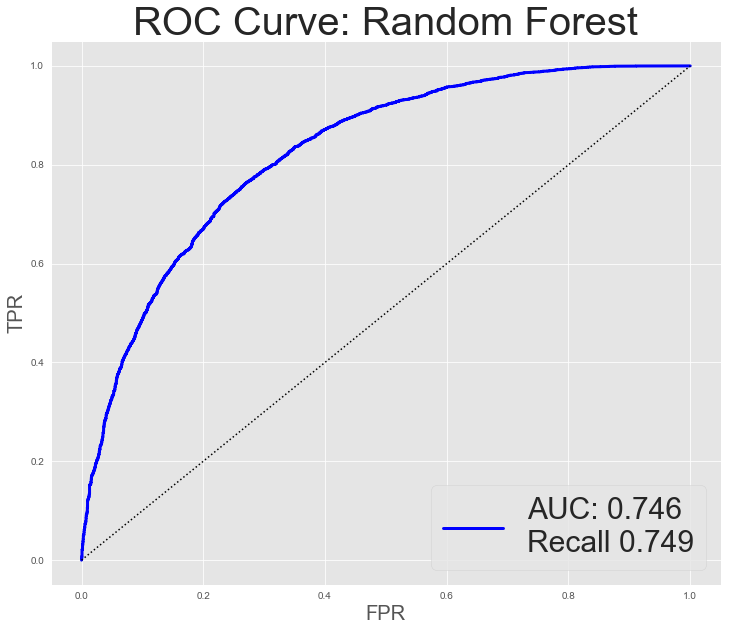

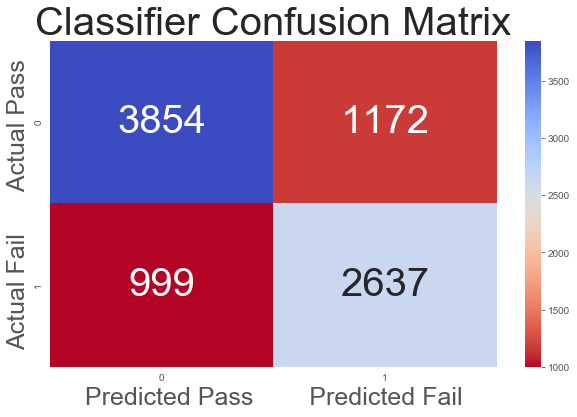

In [17]:
    print_roc_curve(y_test, probas, 'Random Forest', recall)
    plt.savefig('../reports/figures/rf_roc.png')
    print_confusion_matrix(conf_mat, 'Classifier')
    plt.savefig('../reports/figures/rf_conf_mat.png')
    print('\nClassification Report:\n {}'.format(class_report))

## Model Improvement Over Baseline: Predictions Based Solely on demographics

In [18]:
bl_cols = ['gender_M', 'gender_nan', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland','region_South East Region', 'region_South Region', 'region_South West Region', 
        'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'region_nan', 'highest_education_HE Qualification',
       'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification',
       'highest_education_nan', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
       'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'imd_band_nan', 'age_band_35-55', 'age_band_55<=',
       'age_band_nan', 'disability_Y', 'disability_nan']

bl_X_train = X_train[bl_cols]
bl_X_test = X_test[bl_cols]

In [19]:
bl_model = RandomForestClassifier()

In [20]:
bl_model.fit(bl_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
    t = 0.5 # threshold for predicting positive    
    bl_predictions = (bl_model.predict_proba(bl_X_test)[:, 1:] > t)
    bl_roc_auc = roc_auc_score(y_test, bl_predictions)
    bl_probas = bl_model.predict_proba(bl_X_test)[:, :1]
    bl_tprs, bl_fprs, bl_thresh = roc_curve(y_test, bl_probas)
    bl_recall = recall_score(y_test, bl_predictions, average='micro')
    bl_conf_mat = confusion_matrix(y_test, bl_predictions) # sklearn way
    bl_class_report = classification_report(y_test, bl_predictions)


Classification Report:
               precision    recall  f1-score   support

       False       0.62      0.72      0.66      5026
        True       0.49      0.38      0.43      3636

   micro avg       0.58      0.58      0.58      8662
   macro avg       0.56      0.55      0.55      8662
weighted avg       0.57      0.58      0.57      8662



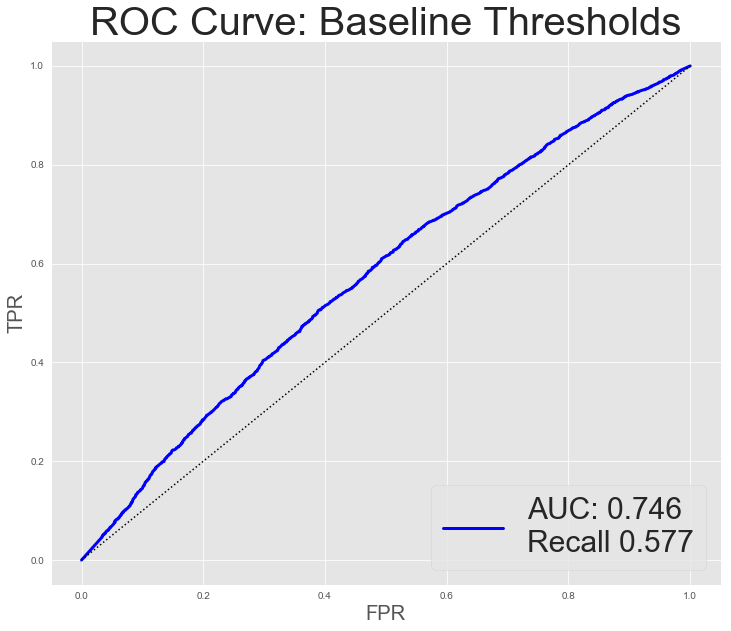

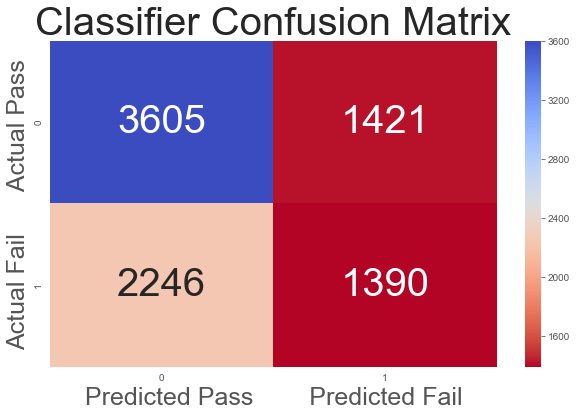

In [22]:
    print_roc_curve(y_test, bl_probas, 'Baseline Thresholds', bl_recall)
    plt.savefig('../reports/figures/bl_roc.png')
    print_confusion_matrix(bl_conf_mat, 'Classifier')
    plt.savefig('../reports/figures/bl_conf_mat.png')
    print('\nClassification Report:\n {}'.format(bl_class_report))

## Permutation Feature Importance

In [18]:
feat_imp = importances(rf_model, X_test, y_test)

In [19]:
print("The ten most important features are:\n{}".format(feat_imp[:10]))

The ten most important features are:
                                      Importance
Feature                                         
avg_score                                 0.0662
highest_education_Lower Than A Level      0.0066
sum_days_vle_accessed                     0.0062
code_module_GGG                           0.0060
sum_click_page                            0.0044
score_first_assessment                    0.0042
sum_click_subpage                         0.0034
days_early_first_assessment               0.0032
sum_click_homepage                        0.0030
sum_click_quiz                            0.0028


## Primary Features by Target

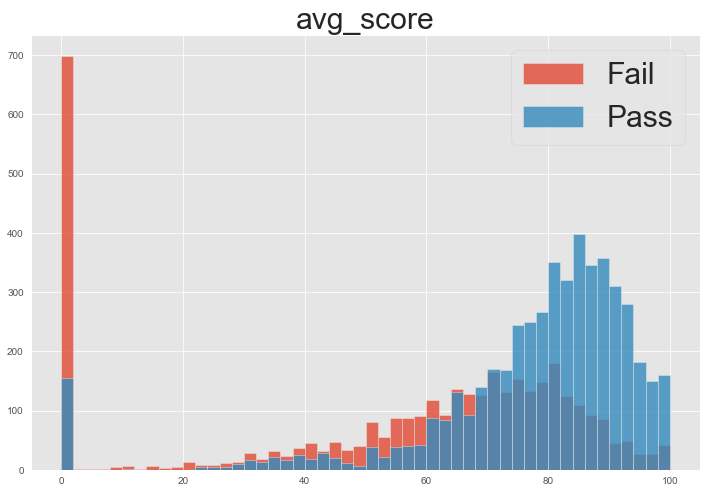

In [20]:
plot_target_hist('avg_score', (0,100))

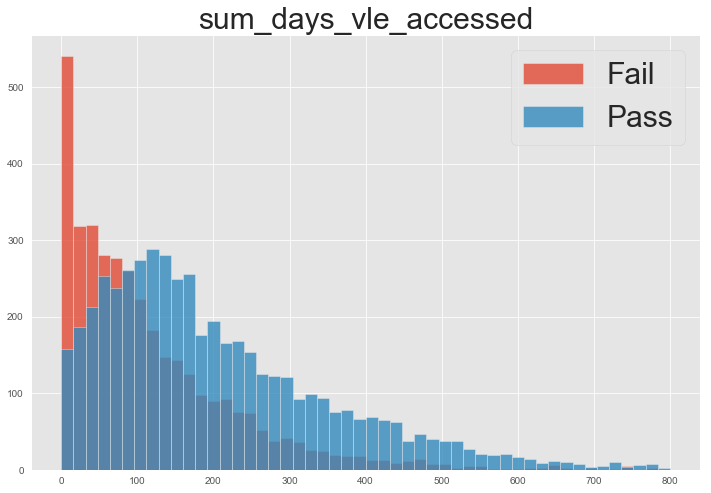

In [21]:
plot_target_hist('sum_days_vle_accessed', (0,800))

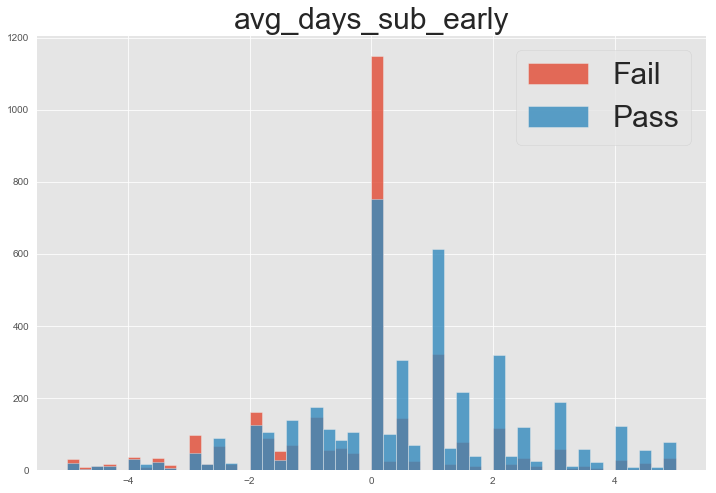

In [22]:
plot_target_hist('avg_days_sub_early', (-5,5))

## Choosing a Threshold

In [23]:
thresh_df = pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:200]
print("A summary of how prediction rates are affected by threshold:\n{}".format(thresh_df))

A summary of how prediction rates are affected by threshold:
          fprs      tprs  Thresholds
800   0.133113  0.566057    0.717140
1000  0.171617  0.625746    0.688625
1200  0.213696  0.692002    0.651421
1400  0.257701  0.748309    0.613464
1600  0.308581  0.795862    0.576925
1800  0.360286  0.842220    0.537464
2000  0.419417  0.882411    0.491877
2200  0.487074  0.917429    0.436776
2400  0.573982  0.946677    0.369149
2600  0.669417  0.972742    0.288895
2800  0.815732  0.996419    0.148528


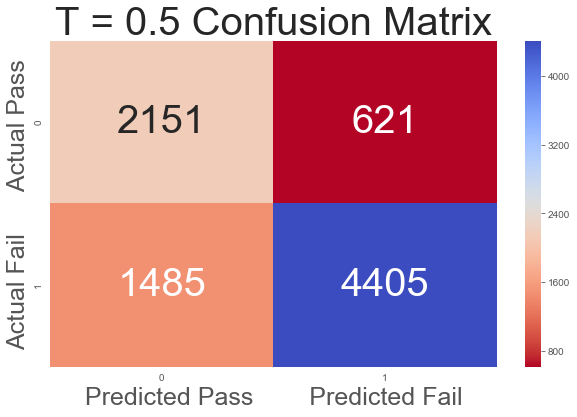


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662



In [24]:
    t = 0.5 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print_confusion_matrix(standard_confusion_matrix(y_test, predictions), "T = 0.5")
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))

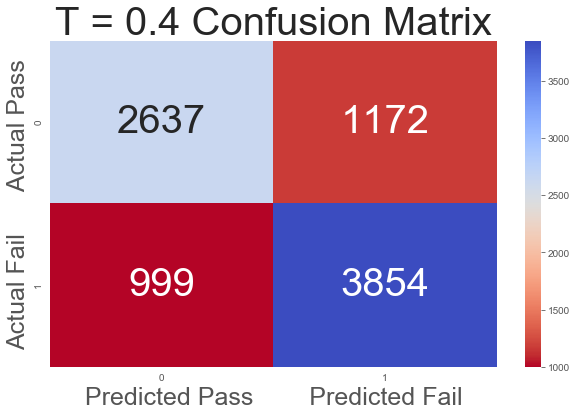


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78      5026
        True       0.69      0.73      0.71      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.74      0.75      0.74      8662
weighted avg       0.75      0.75      0.75      8662



In [25]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print_confusion_matrix(standard_confusion_matrix(y_test, predictions), "T = 0.4")
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))

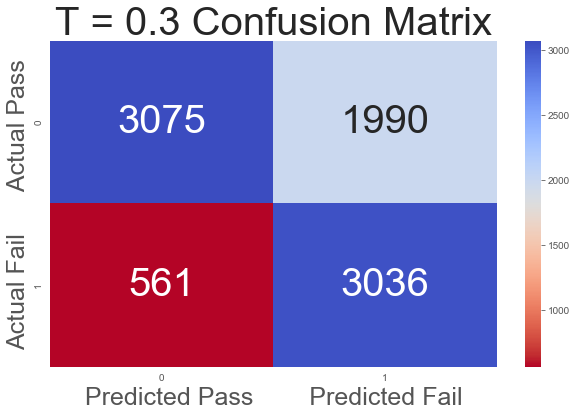


Classification Report at Threshold 0.3:
               precision    recall  f1-score   support

       False       0.84      0.60      0.70      5026
        True       0.61      0.85      0.71      3636

   micro avg       0.71      0.71      0.71      8662
   macro avg       0.73      0.72      0.71      8662
weighted avg       0.74      0.71      0.71      8662



In [26]:
    t = 0.3 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print_confusion_matrix(standard_confusion_matrix(y_test, predictions), "T = 0.3")
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))

## Who is the model performing Poorly On?

In [27]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)

In [28]:
correct_prediction = predictions.ravel() == y_test

In [29]:
X_test_with_pred = X_test

In [30]:
X_test_with_pred['correct_prediction'] = correct_prediction

In [31]:
X_test_corr_pred = X_test_with_pred[X_test_with_pred['correct_prediction'] == True]
X_test_wrong_pred = X_test_with_pred[X_test_with_pred['correct_prediction'] == False]

In [32]:
X_test_corr_pred.describe()

,num_of_prev_attempts,studied_credits,module_presentation_length,sum_click_dataplus,sum_click_dualpane,sum_click_externalquiz,sum_click_forumng,sum_click_glossary,sum_click_homepage,sum_click_htmlactivity,sum_click_oucollaborate,sum_click_oucontent,sum_click_ouelluminate,sum_click_ouwiki,sum_click_page,sum_click_questionnaire,sum_click_quiz,sum_click_repeatactivity,sum_click_resource,sum_click_sharedsubpage,sum_click_subpage,sum_click_url,sum_days_vle_accessed,max_clicks_one_day,first_date_vle_accessed,avg_score,avg_days_sub_early,days_early_first_assessment,score_first_assessment,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_module_nan,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,code_presentation_nan,gender_M,gender_nan,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,region_nan,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,highest_education_nan,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_nan,age_band_35-55,age_band_55<=,age_band_nan,disability_Y,disability_nan
count,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.0,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.0,6491.000000,6491.000000,6491.000000,6491.0,6491.000000,6491.0,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.0,6491.000000,6491.000000,6491.000000,6491.000000,6491.0,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000,6491.0,6491.000000,6491.0
mean,0.150824,75.533816,256.384532,0.025420,0.496688,0.915113,161.485749,1.555076,122.197350,0.303189,1.503929,152.024033,0.699276,8.657526,1.390695,0.981975,89.355569,0.0,20.272377,0.003697,60.242644,11.305808,175.967339,40.060083,-8.663534,66.636638,1.102796,2.763365,65.668310,0.237714,0.123864,0.189031,0.095671,0.244955,0.083192,0.0,0.287321,0.222462,0.342782,0.0,0.555538,0.0,0.069327,0.040826,0.100601,0.055461,0.080881,0.109228,0.064705,0.096903,0.071946,0.071330,0.071792,0.061008,0.0,0.152057,0.389308,0.008011,0.009244,0.0,0.101063,0.104914,0.110461,0.098136,0.101833,0.085503,0.097212,0.082114,0.085965,0.036358,0.297951,0.006162,0.0,0.096133,0.0
std,0.470606,37.798989,13.105335,0.493221,1.912681,3.171770,307.218934,12.813376,144.833397,1.367086,3.569790,232.109300,3.952939,21.593962,4.098089,2.828669,194.853721,0.0,58.572382,0.076430,76.813049,17.177780,158.969138,48.226502,10.301773,29.067175,6.733300,8.065511,31.025346,0.425716,0.329451,0.391563,0.294162,0.430093,0.276194,0.0,0.452547,0.415932,0.474676,0.0,0.496944,0.0,0.254029,0.197902,0.300823,0.228896,0.272674,0.311949,0.246024,0.295849,0.258418,0.257394,0.258163,0.239363,0.0,0.359103,0.487631,0.089152,0.095705,0.0,0.301435,0.306467,0.313487,0.297521,0.302452,0.279650,0.296268,0.274559,0.280334,0.187194,0.457393,0.078265,0.0,0.294796,0.0
min,0.000000,30.000000,234.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,-137.000000,-123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [33]:
X_test_wrong_pred.describe()

,num_of_prev_attempts,studied_credits,module_presentation_length,sum_click_dataplus,sum_click_dualpane,sum_click_externalquiz,sum_click_forumng,sum_click_glossary,sum_click_homepage,sum_click_htmlactivity,sum_click_oucollaborate,sum_click_oucontent,sum_click_ouelluminate,sum_click_ouwiki,sum_click_page,sum_click_questionnaire,sum_click_quiz,sum_click_repeatactivity,sum_click_resource,sum_click_sharedsubpage,sum_click_subpage,sum_click_url,sum_days_vle_accessed,max_clicks_one_day,first_date_vle_accessed,avg_score,avg_days_sub_early,days_early_first_assessment,score_first_assessment,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_module_nan,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,code_presentation_nan,gender_M,gender_nan,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,region_nan,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,highest_education_nan,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_nan,age_band_35-55,age_band_55<=,age_band_nan,disability_Y,disability_nan
count,2171.00000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.0,2171.000000,2171.000000,2171.000000,2171.0,2171.000000,2171.0,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.0,2171.000000,2171.000000,2171.000000,2171.000000,2171.0,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.0,2171.000000,2171.0
mean,0.15707,75.663289,255.446799,0.013358,0.342239,1.128052,128.424228,1.346845,106.518194,0.265776,1.441732,126.572547,0.743436,8.657301,1.536619,0.849839,76.621833,0.001382,18.389682,0.007370,56.314141,9.501152,154.822202,38.188392,-8.103178,70.302434,0.883310,2.807462,68.857209,0.238139,0.120221,0.190696,0.071856,0.251958,0.100415,0.0,0.291571,0.252879,0.307232,0.0,0.537540,0.0,0.080608,0.046983,0.088899,0.054353,0.087517,0.116997,0.063565,0.081069,0.070014,0.063565,0.082450,0.048365,0.0,0.129894,0.417319,0.011055,0.010134,0.0,0.100415,0.107784,0.106863,0.096269,0.099033,0.101336,0.087517,0.083832,0.073238,0.035928,0.269922,0.005527,0.0,0.100875,0.0
std,0.45611,38.325220,13.209175,0.358320,1.616550,7.957734,274.907271,13.836601,129.908326,1.255705,3.684904,187.244407,4.075559,19.468905,3.932954,2.671323,158.016814,0.064386,24.905280,0.117348,66.339233,13.458534,132.014301,38.928754,10.946979,19.875179,7.194962,8.944723,23.926767,0.426043,0.325295,0.392940,0.258309,0.434237,0.300621,0.0,0.454590,0.434762,0.461453,0.0,0.498704,0.0,0.272295,0.211651,0.284664,0.226765,0.282657,0.321490,0.244033,0.273003,0.255229,0.244033,0.275113,0.214585,0.0,0.336264,0.493230,0.104583,0.100177,0.0,0.300621,0.310179,0.309010,0.295028,0.298775,0.301842,0.282657,0.277200,0.260587,0.186154,0.444021,0.074158,0.0,0.301233,0.0
min,0.00000,30.000000,234.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,-51.000000,-51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

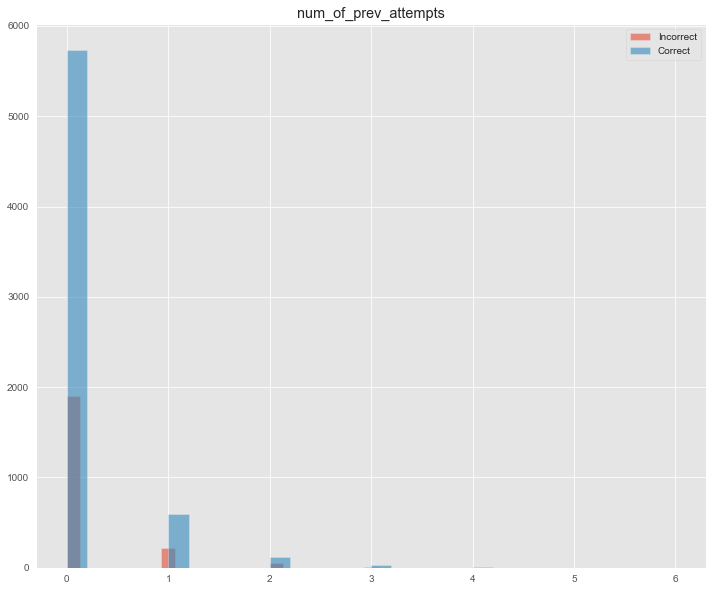

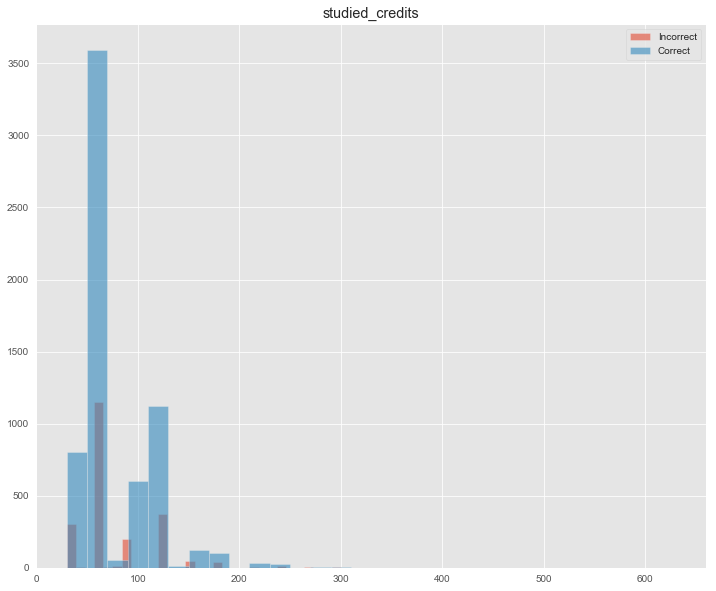

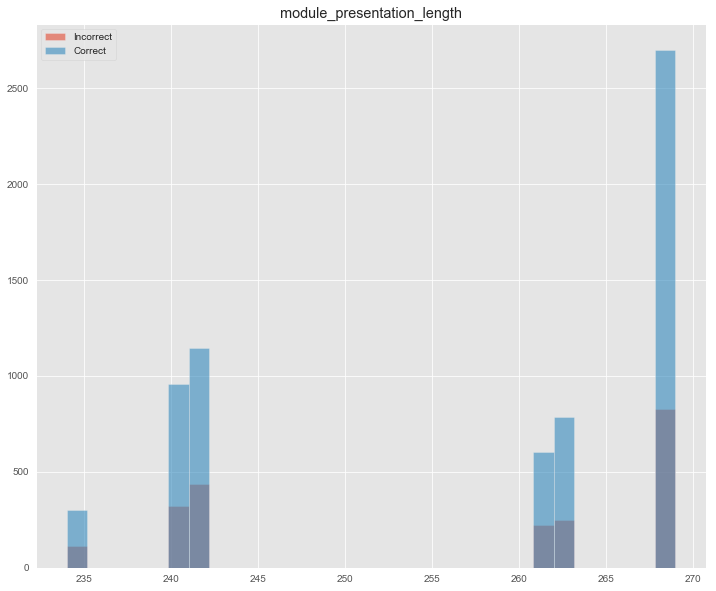

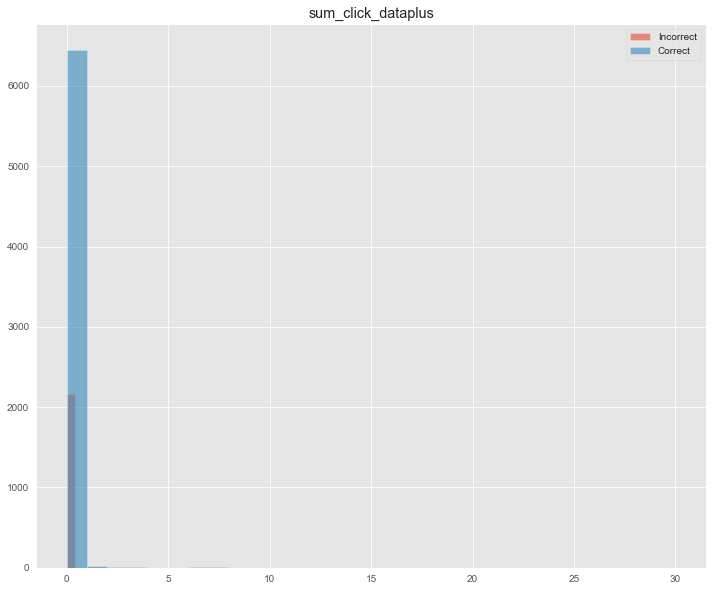

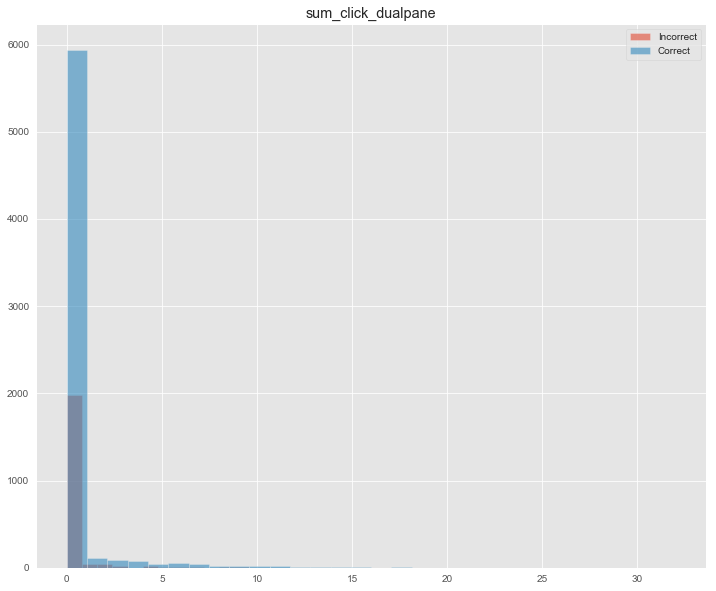

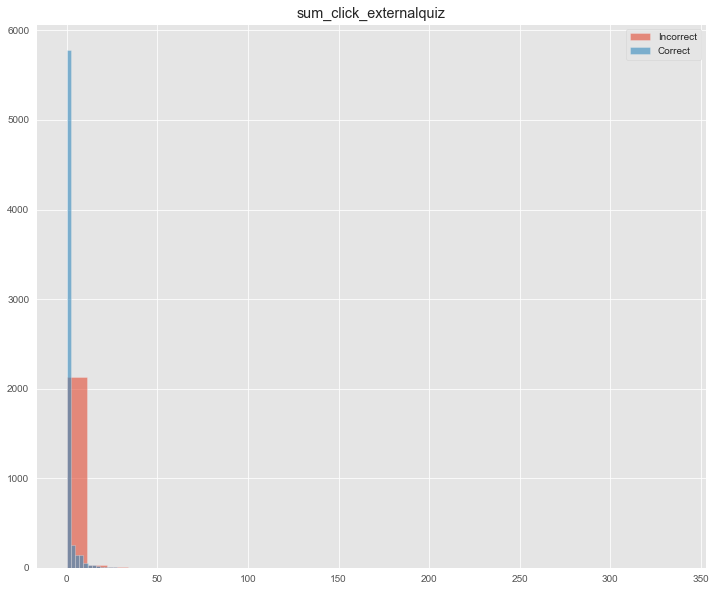

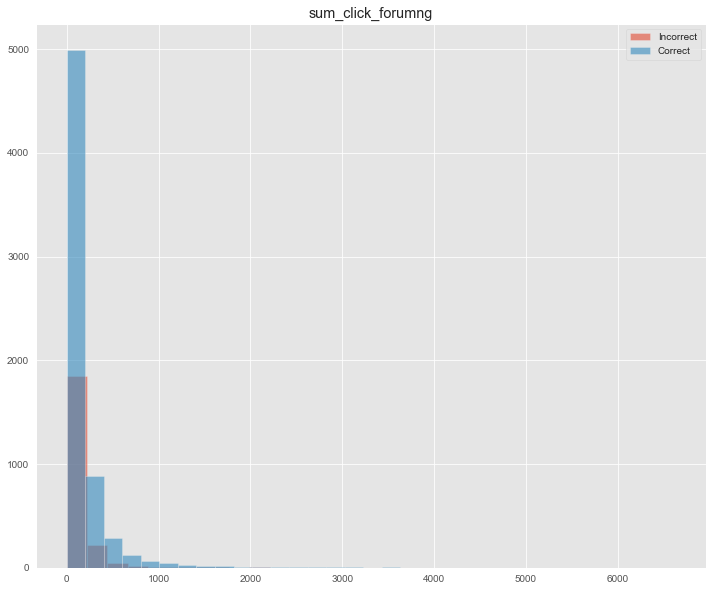

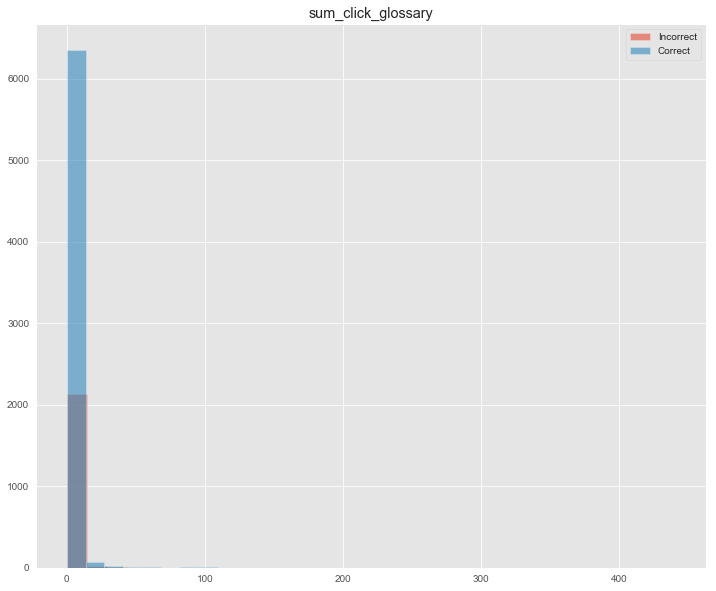

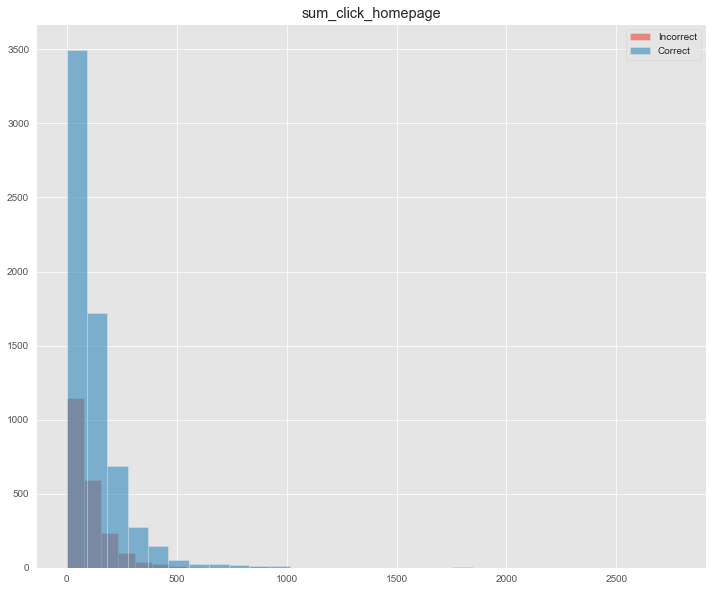

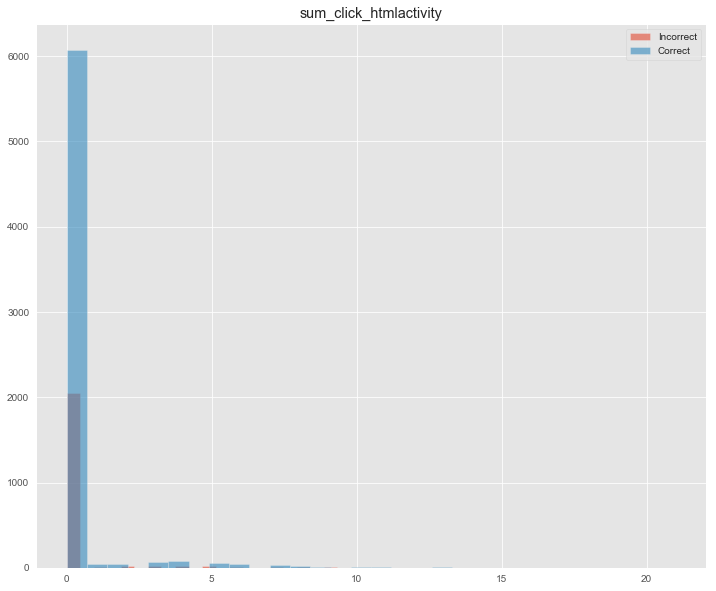

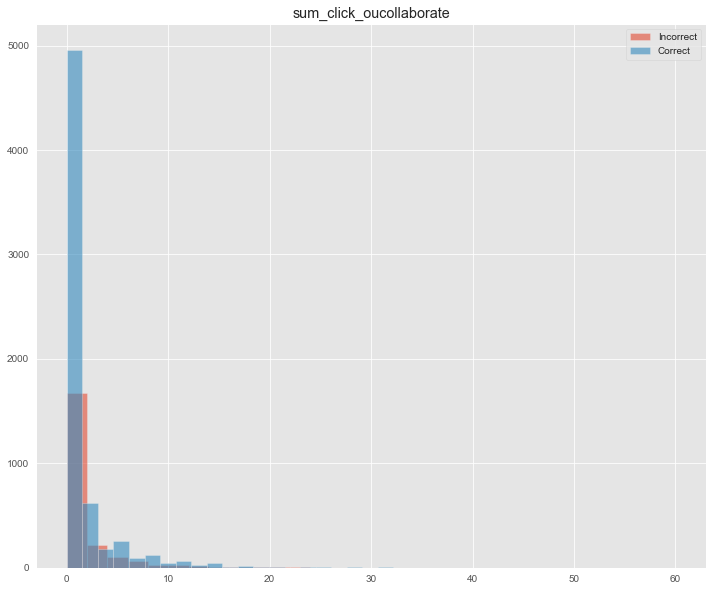

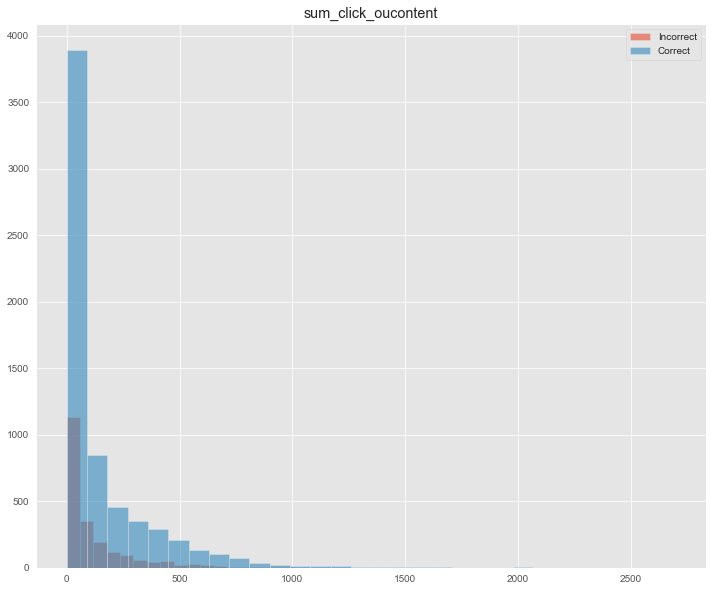

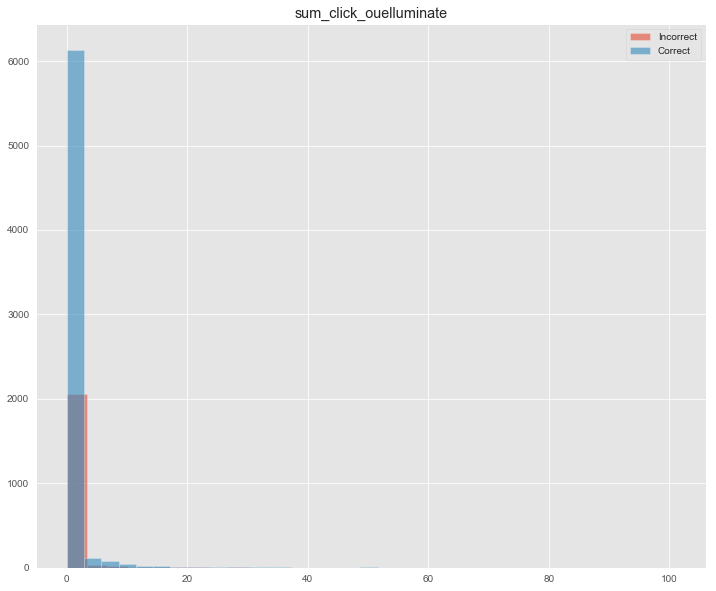

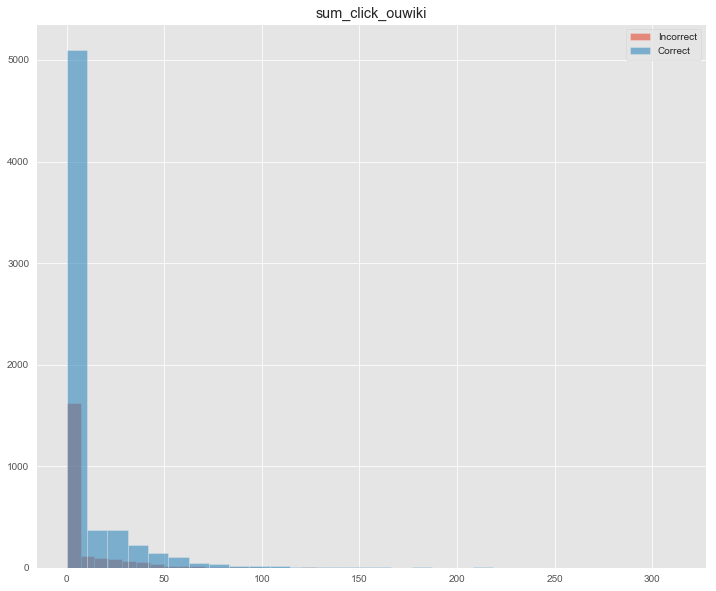

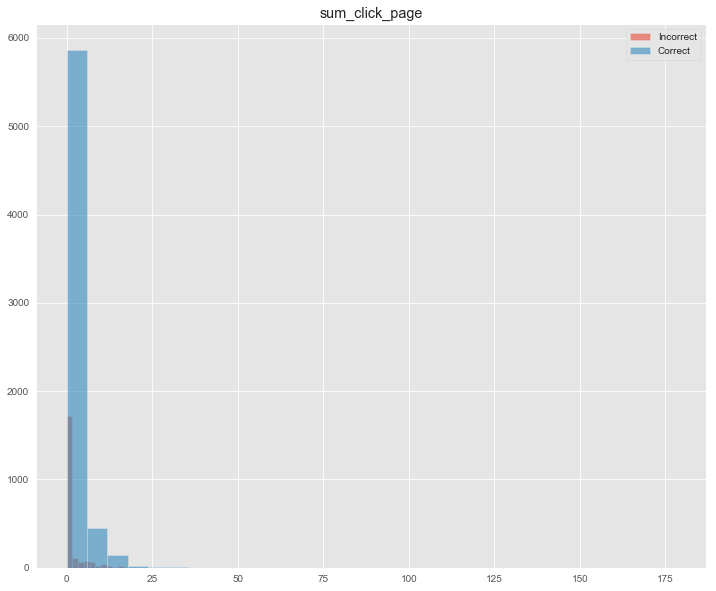

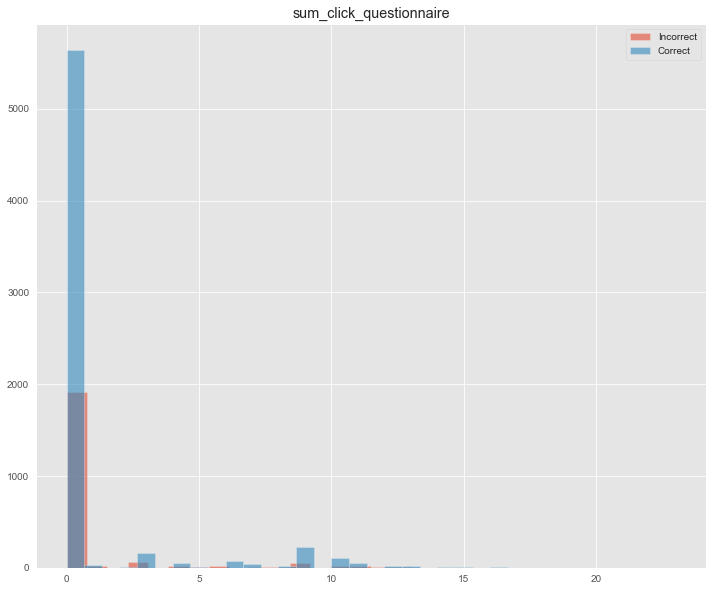

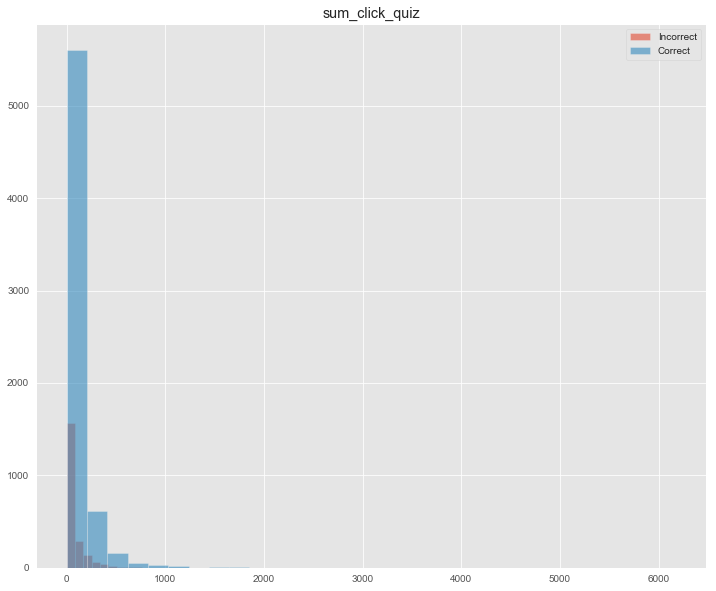

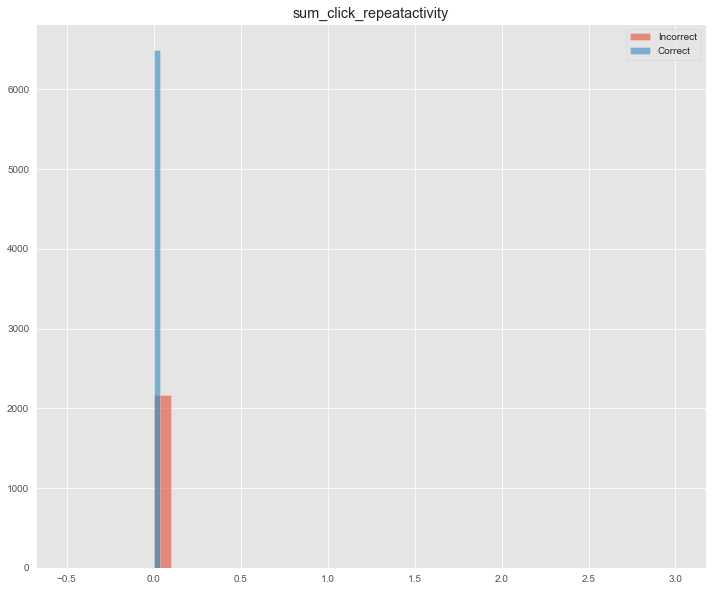

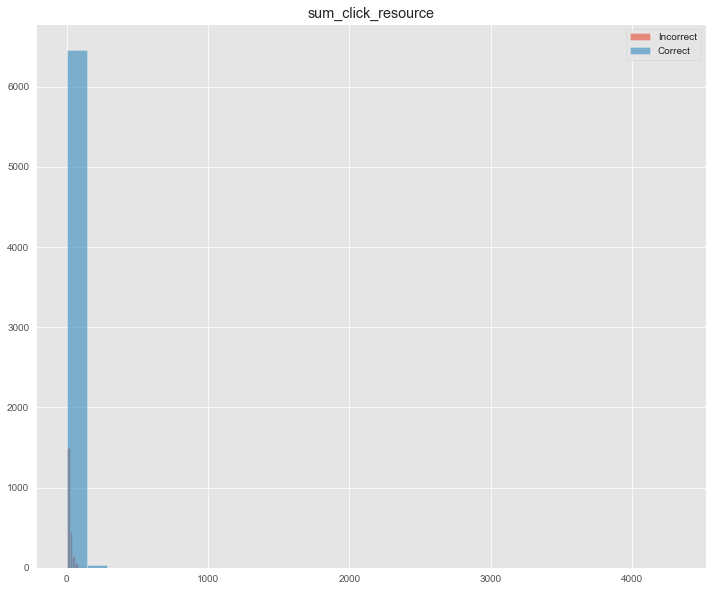

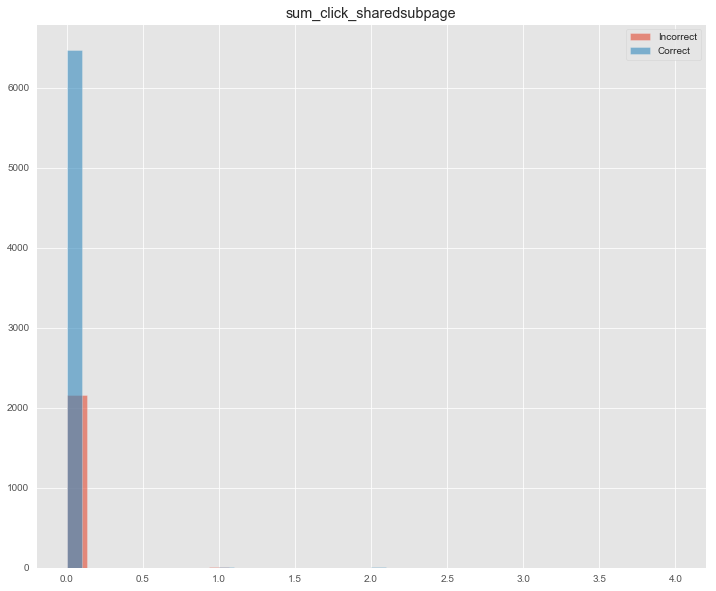

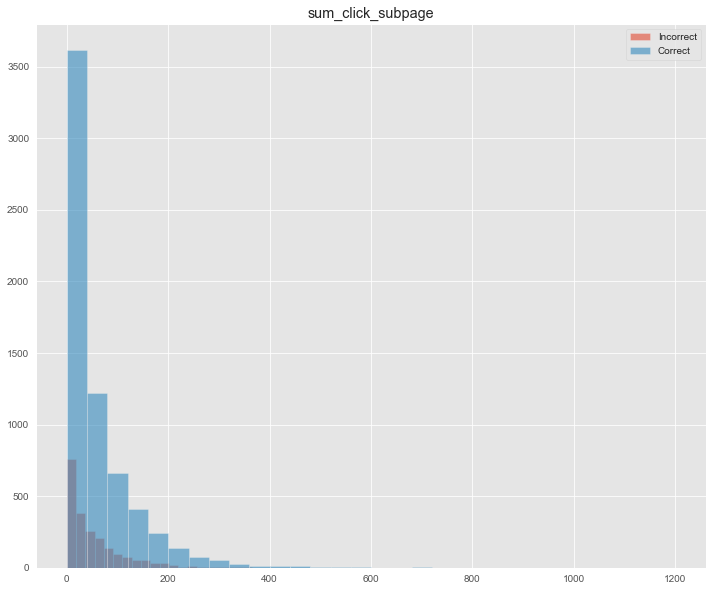

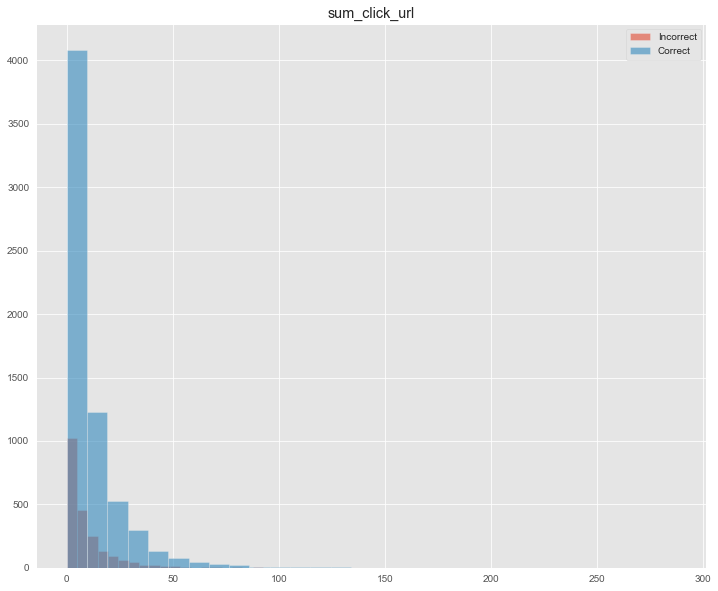

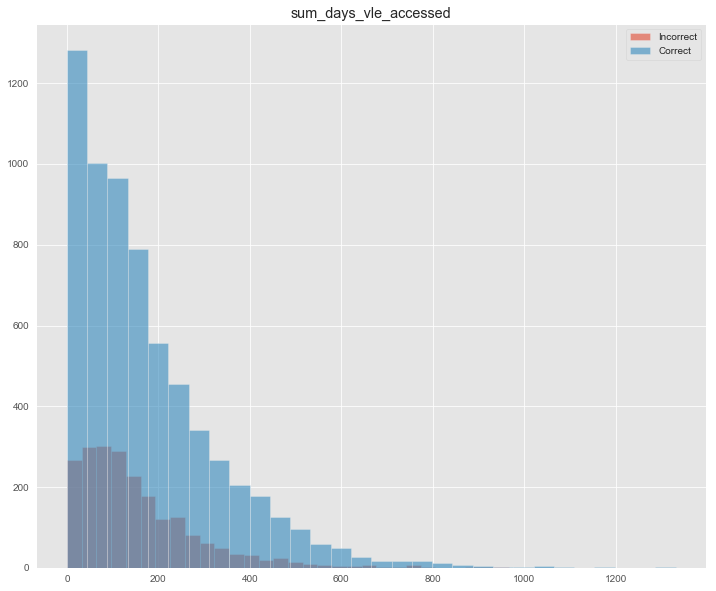

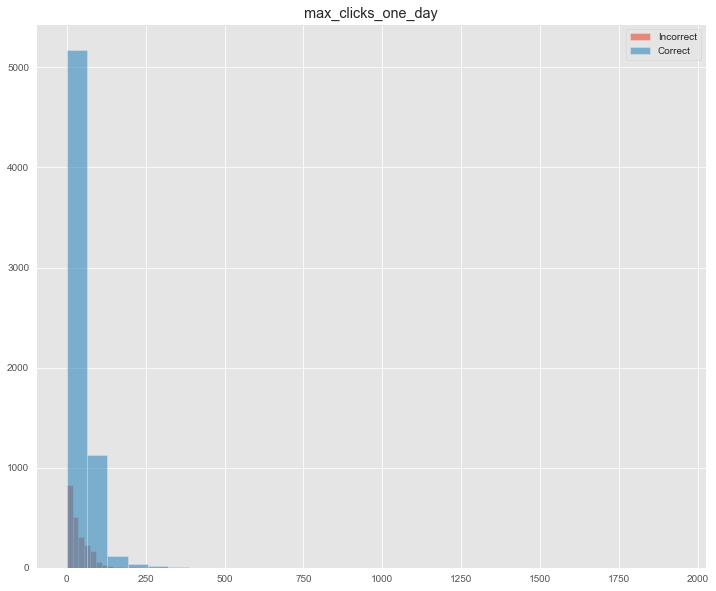

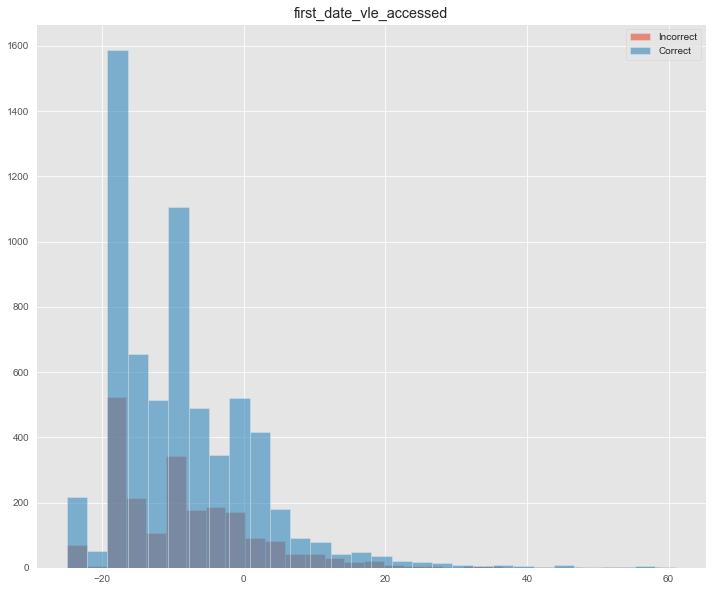

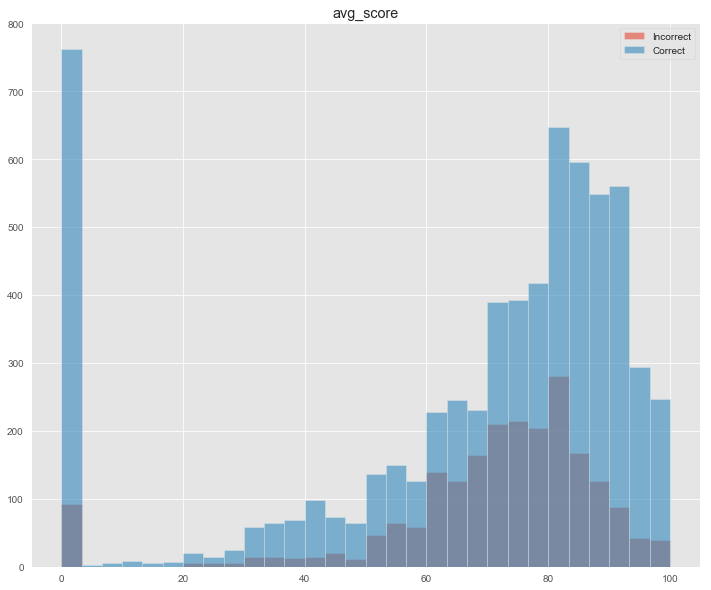

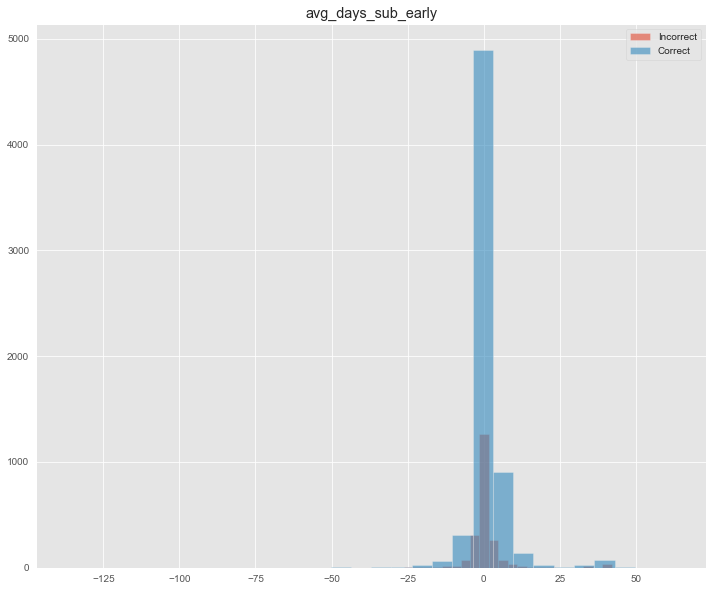

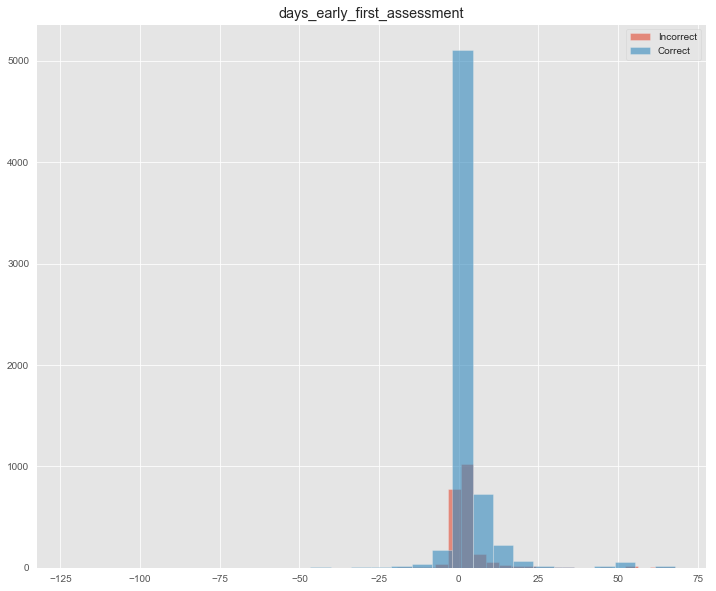

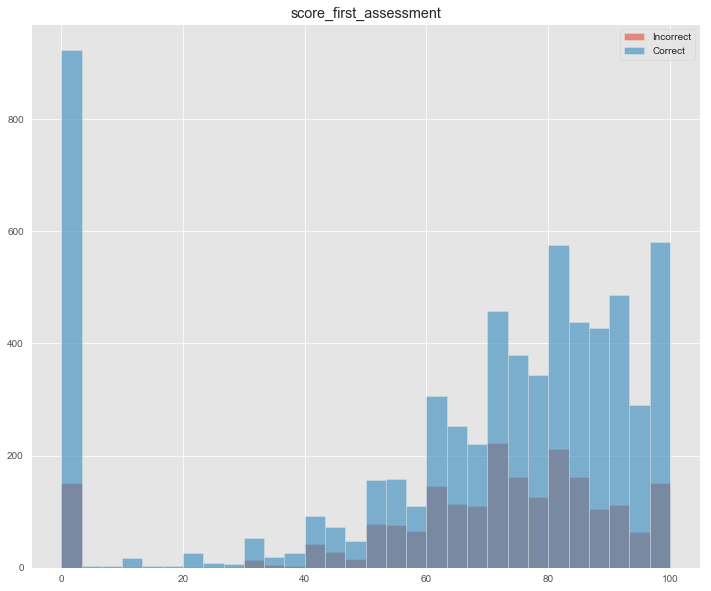

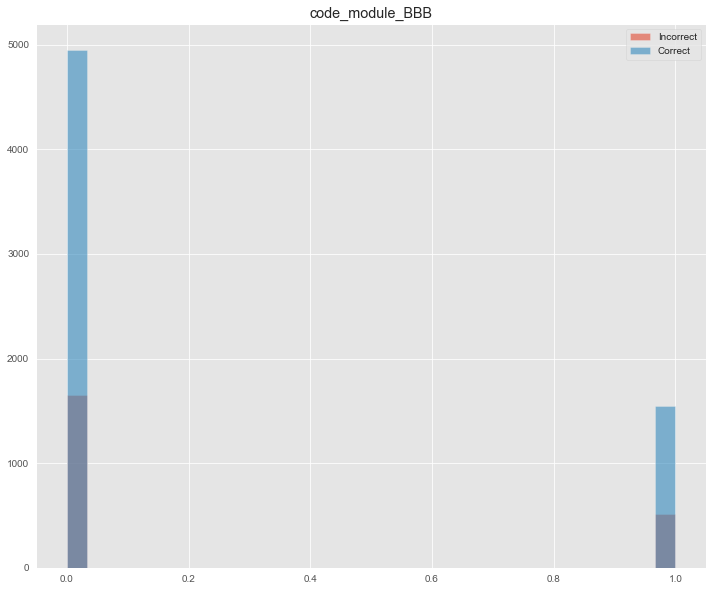

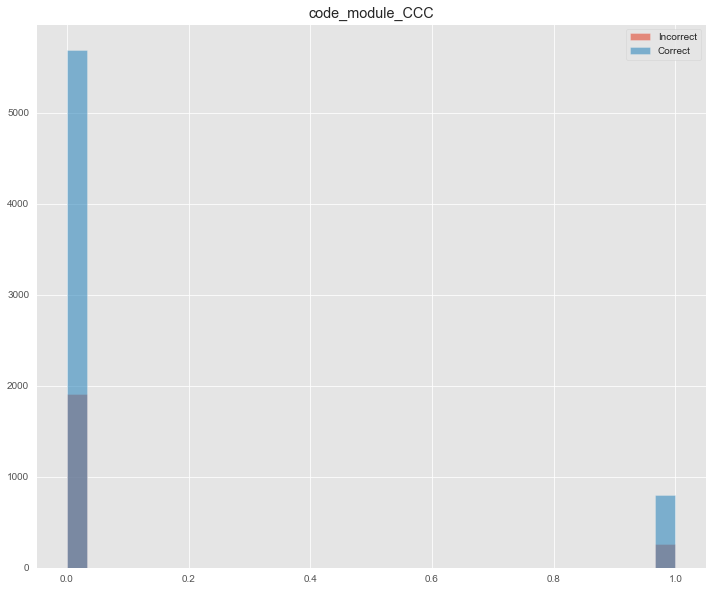

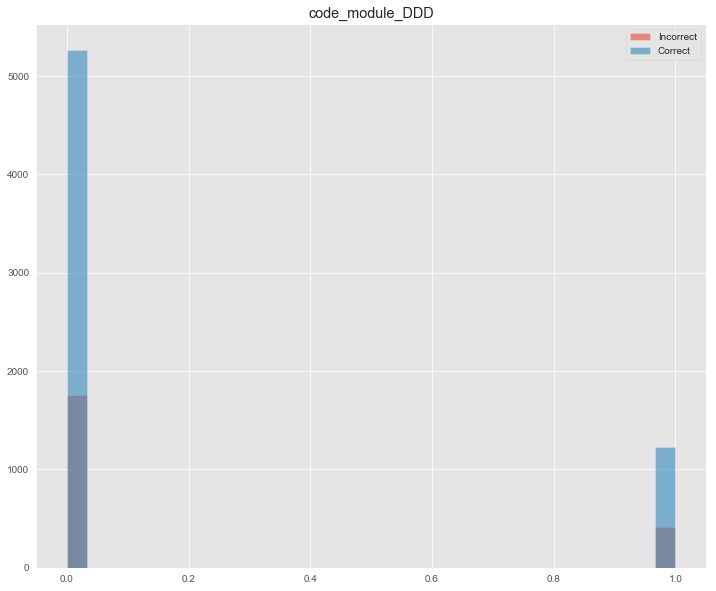

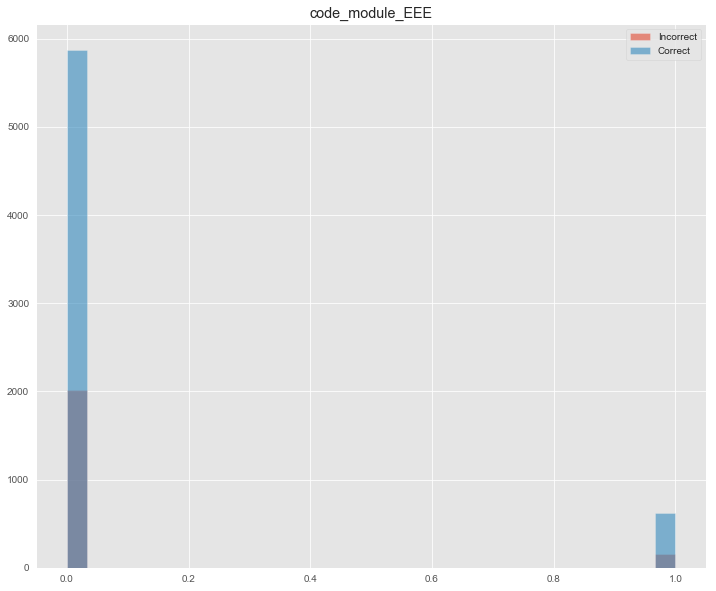

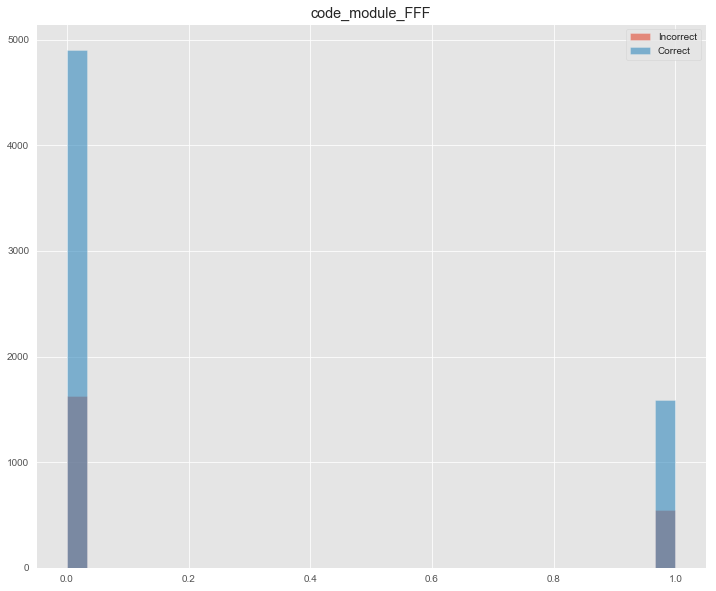

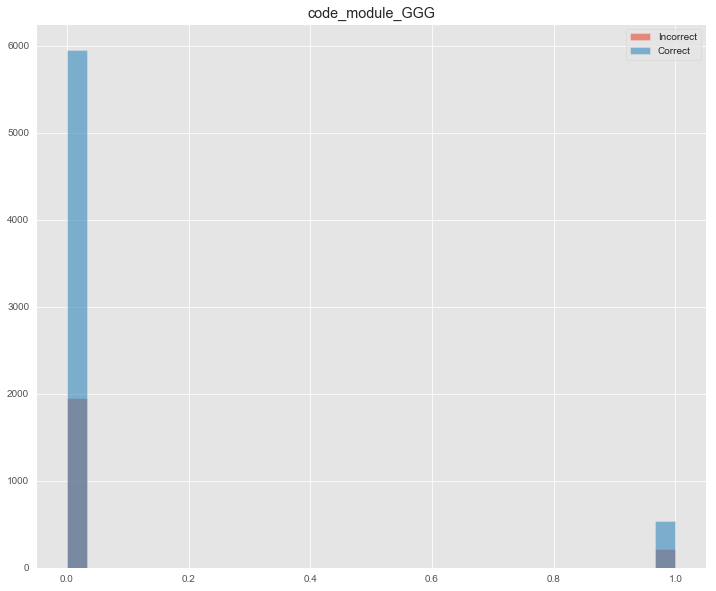

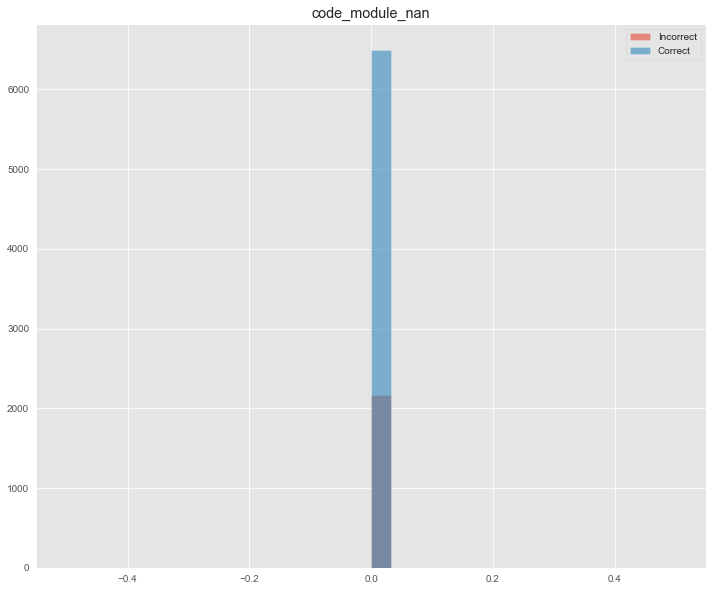

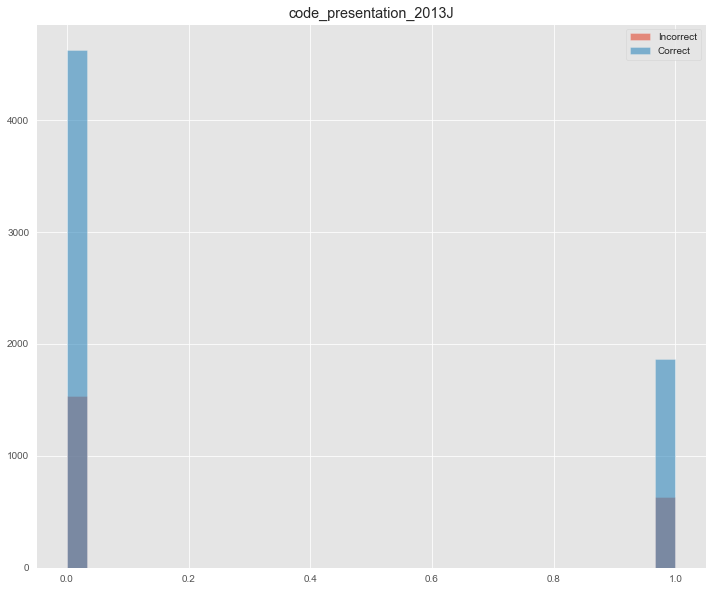

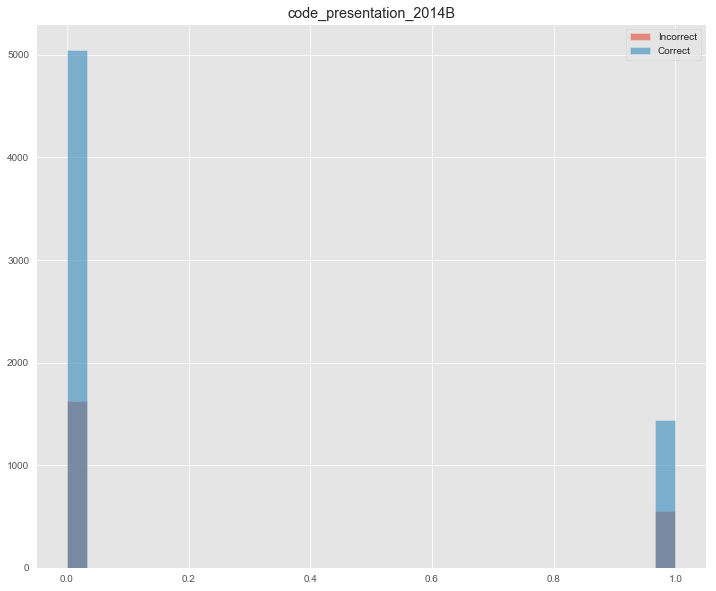

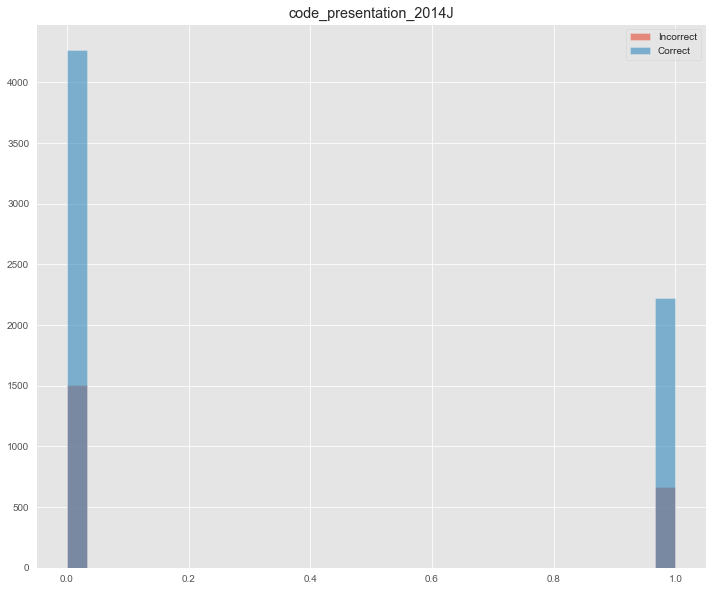

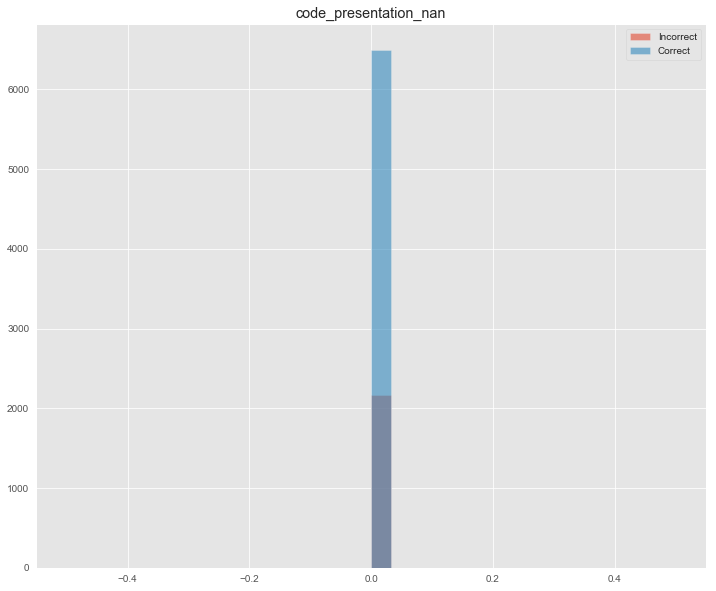

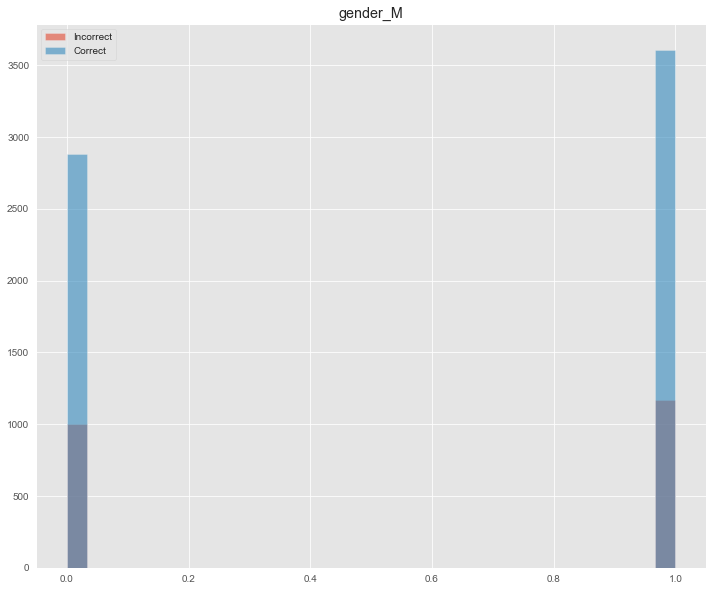

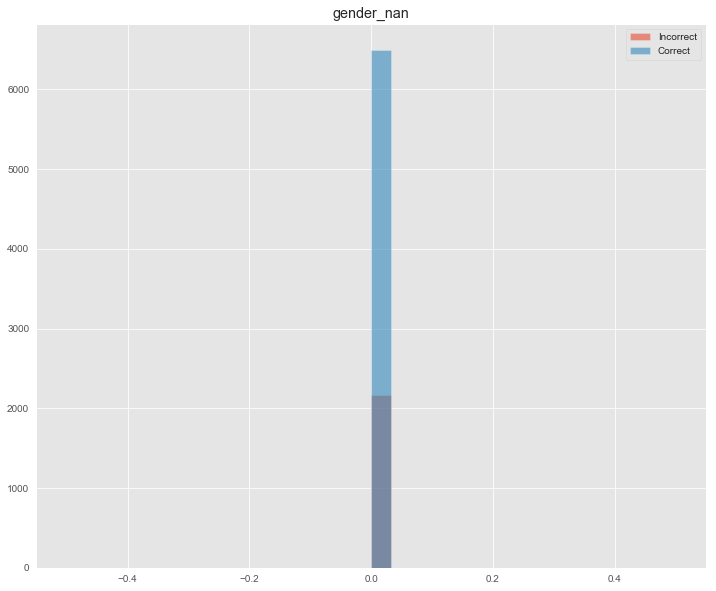

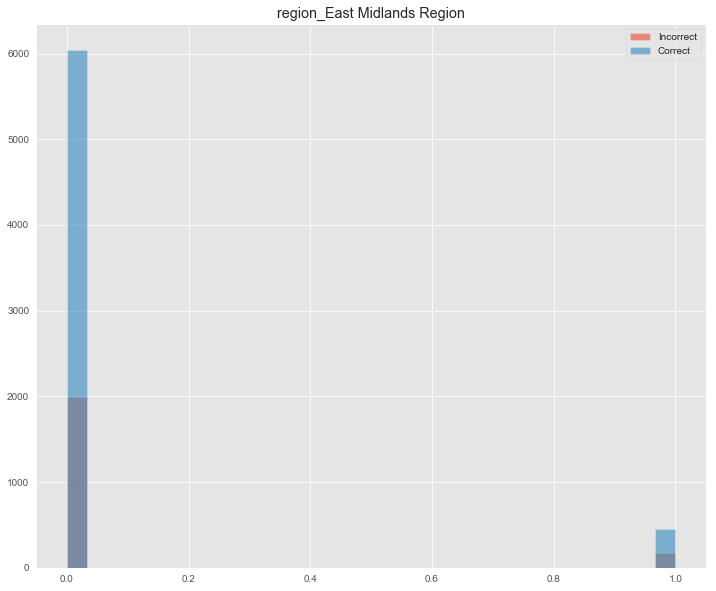

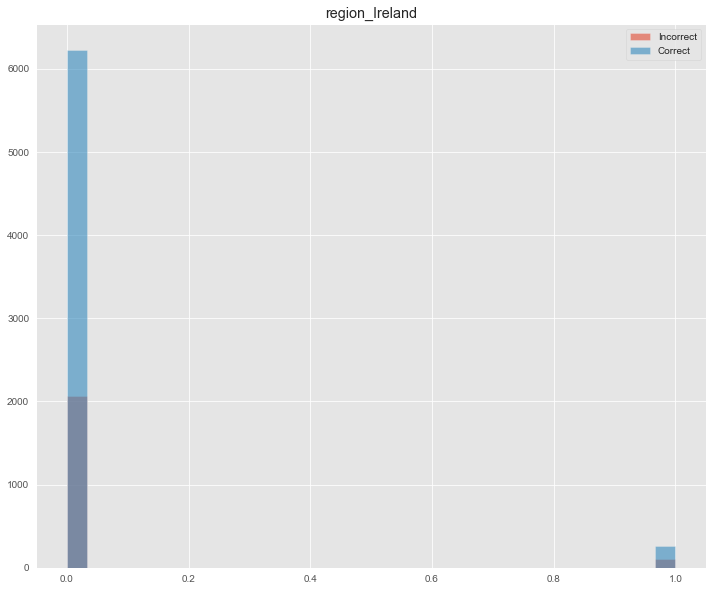

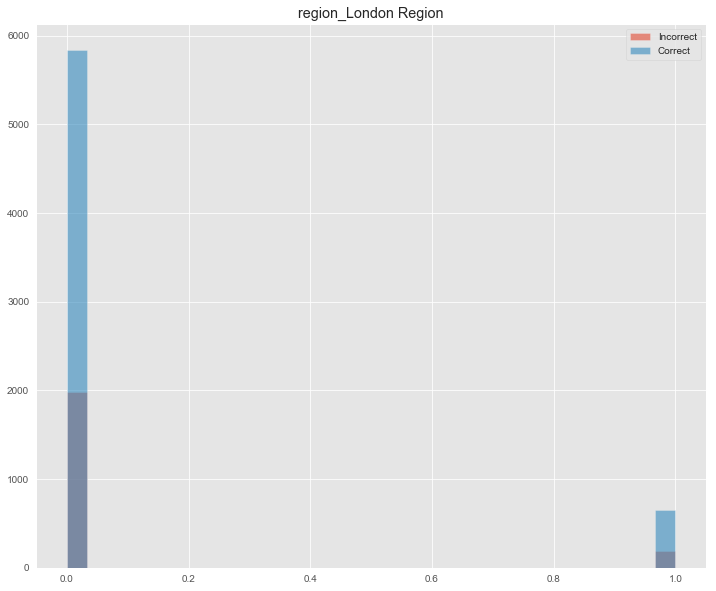

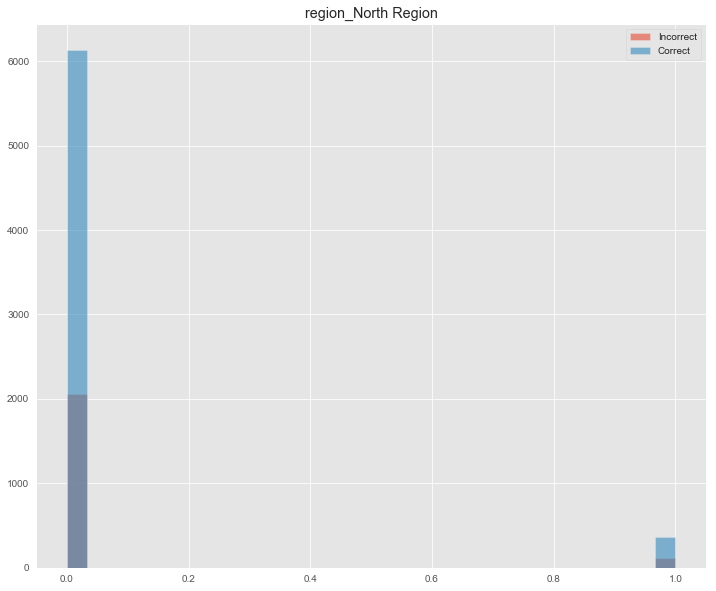

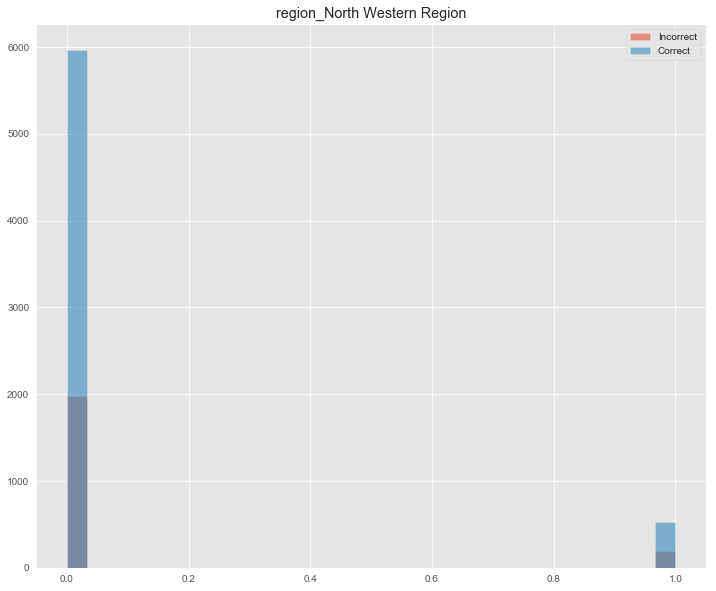

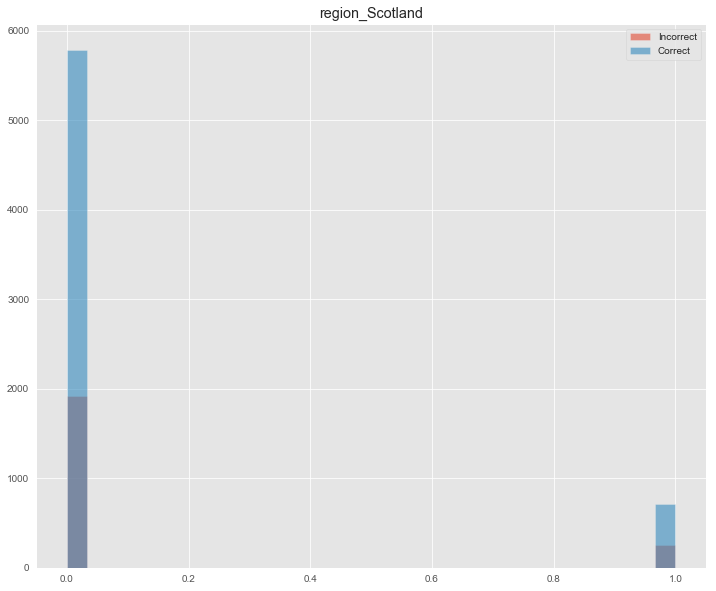

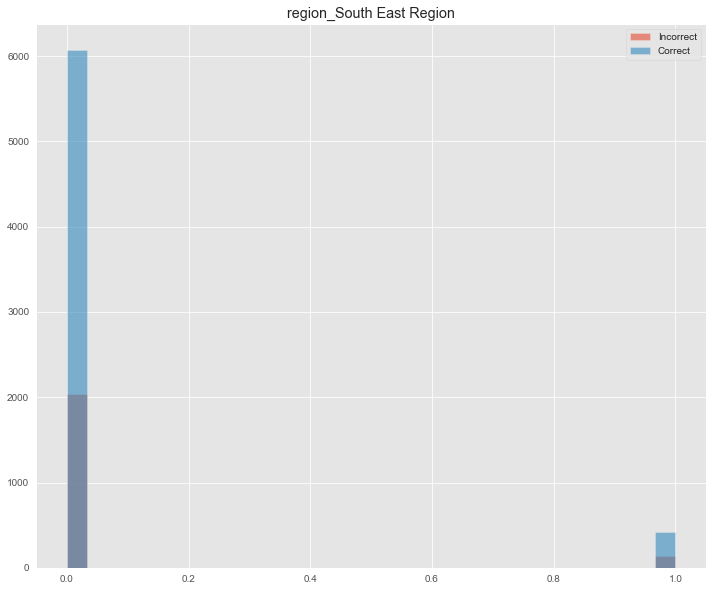

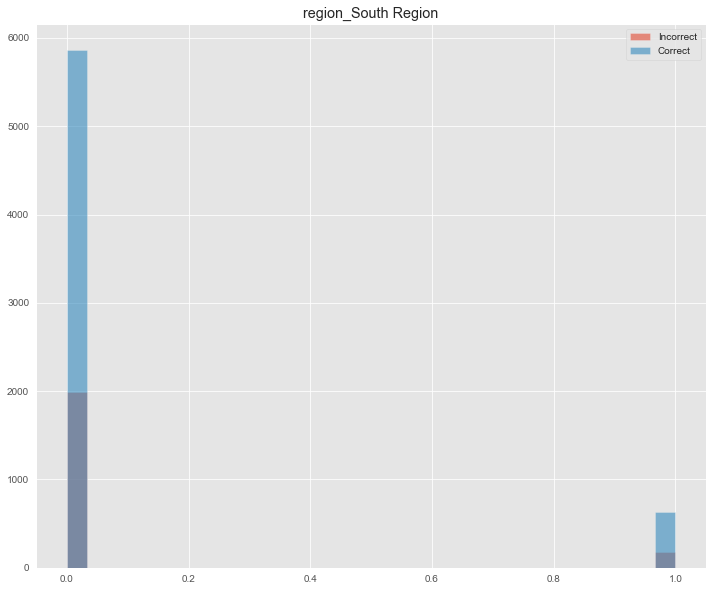

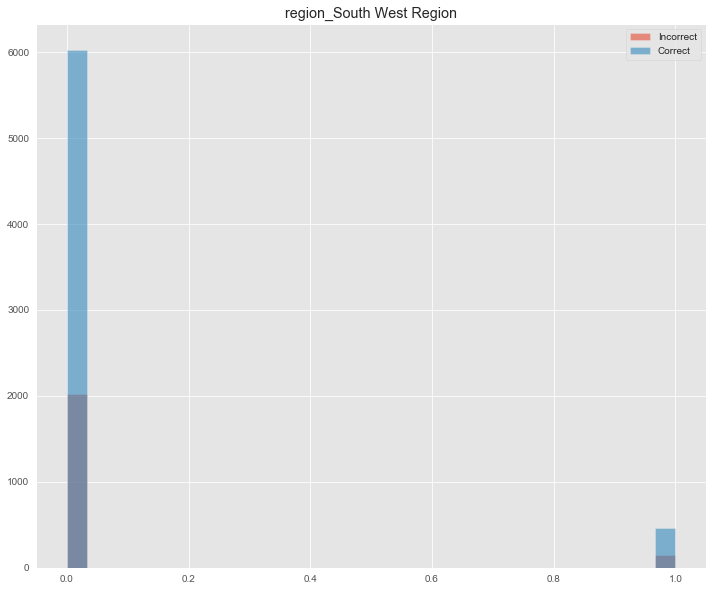

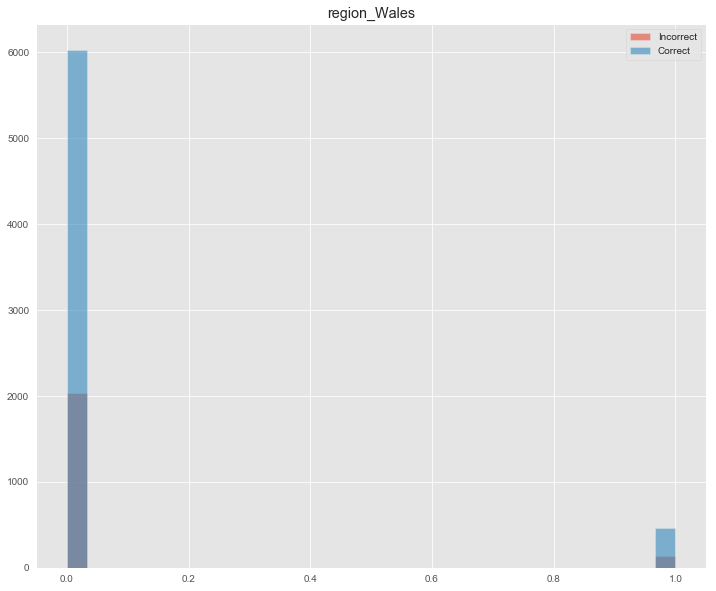

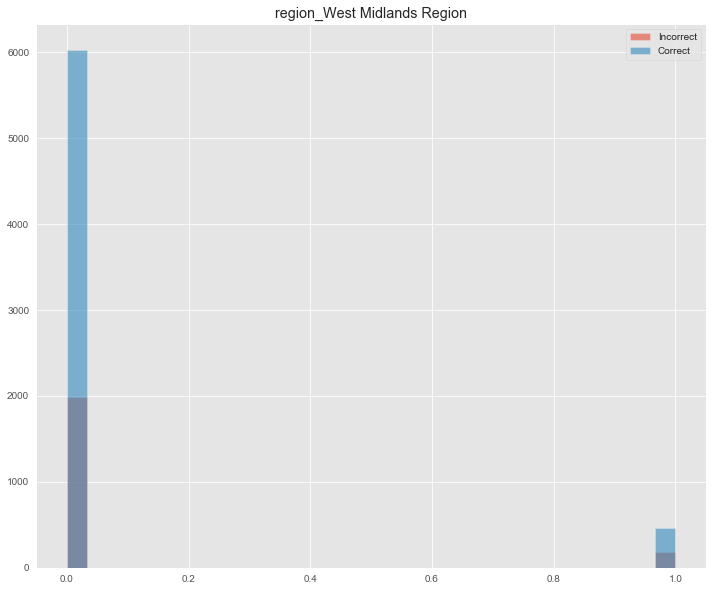

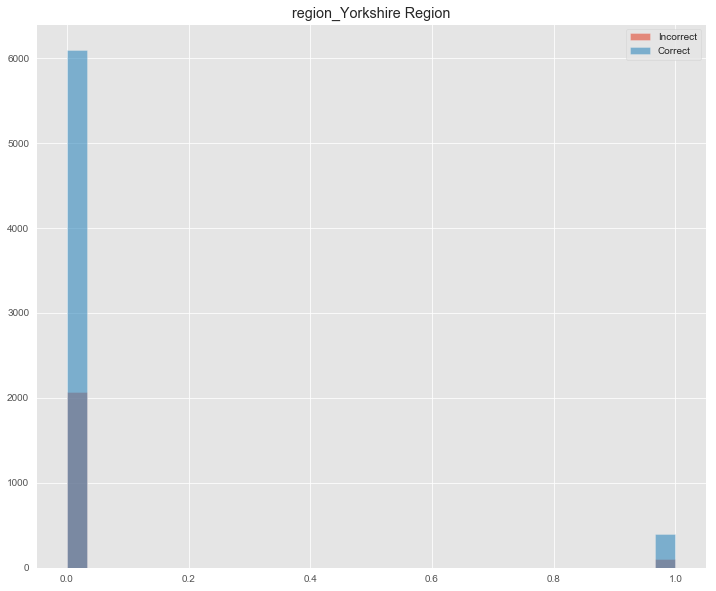

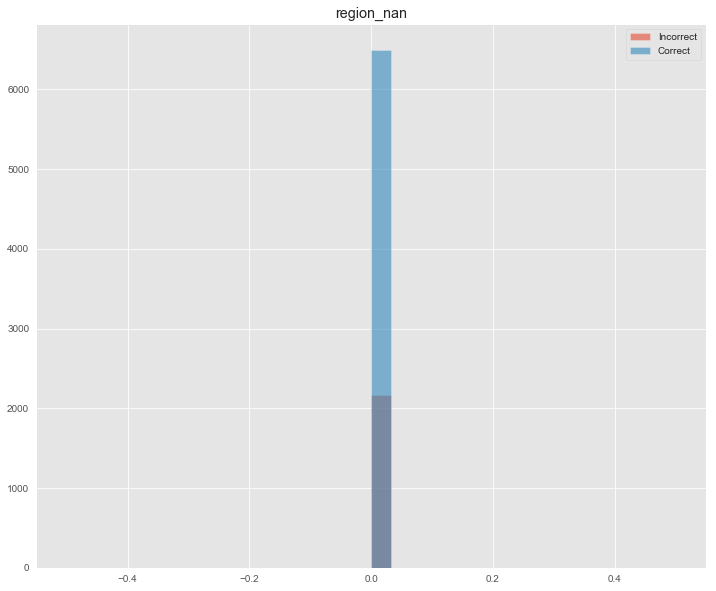

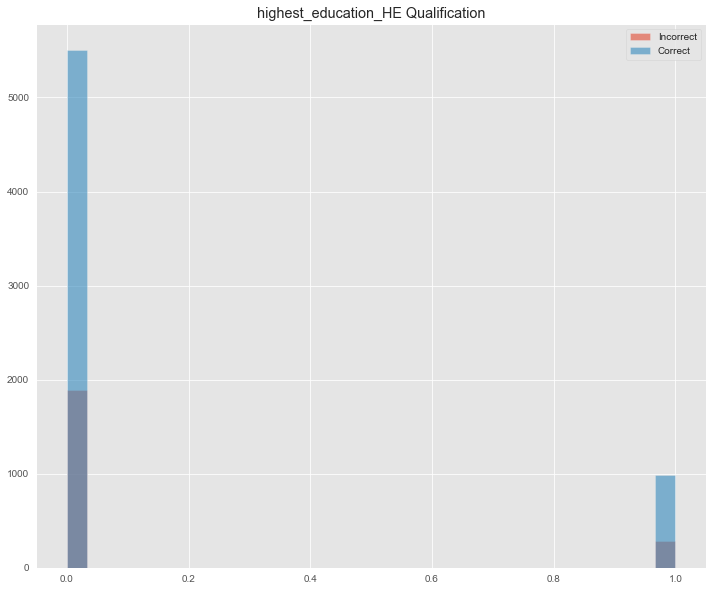

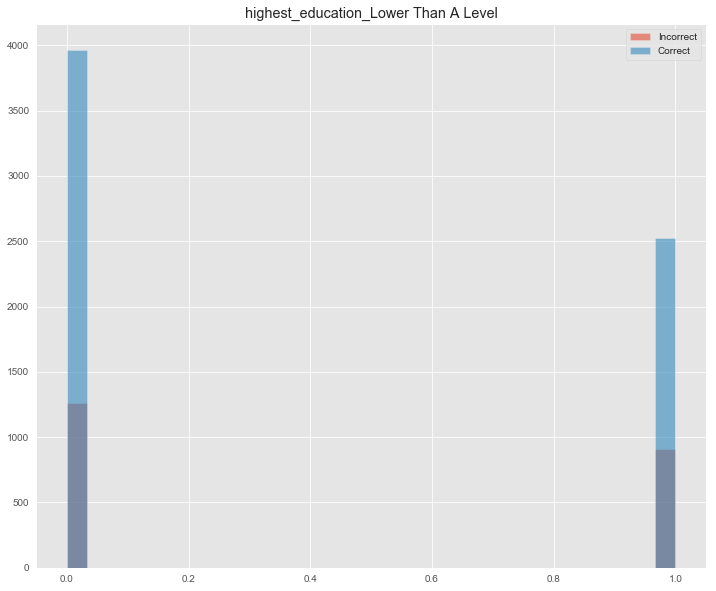

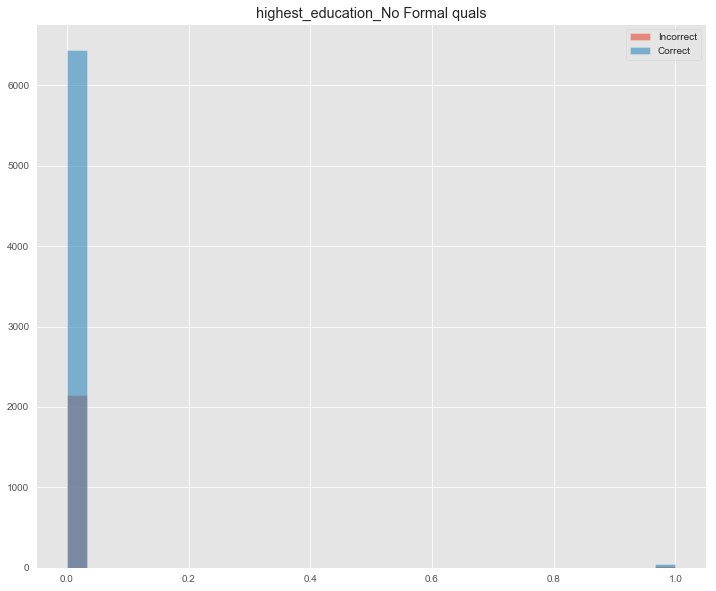

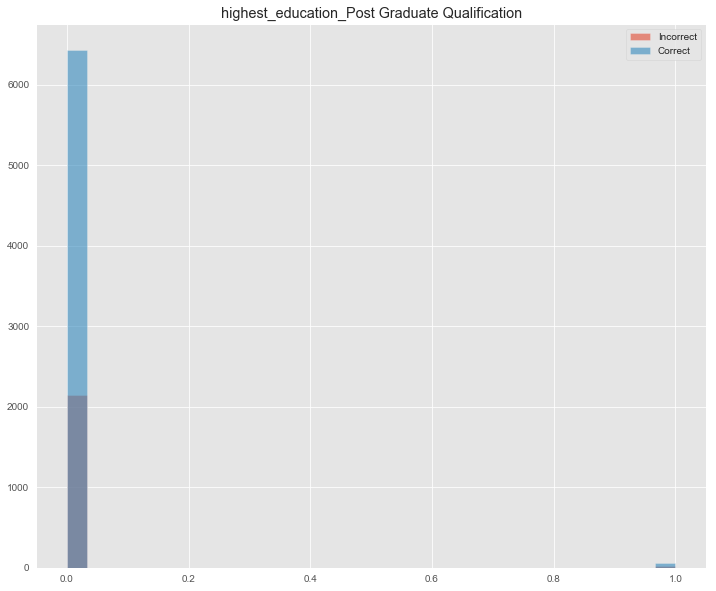

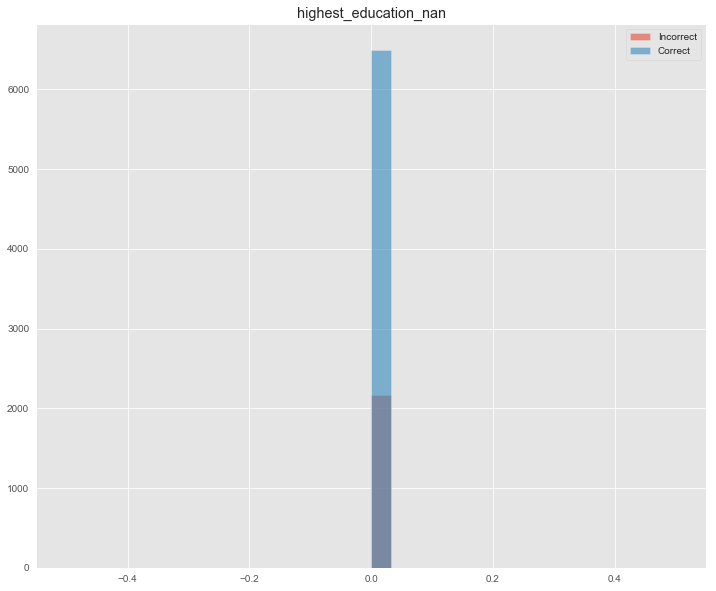

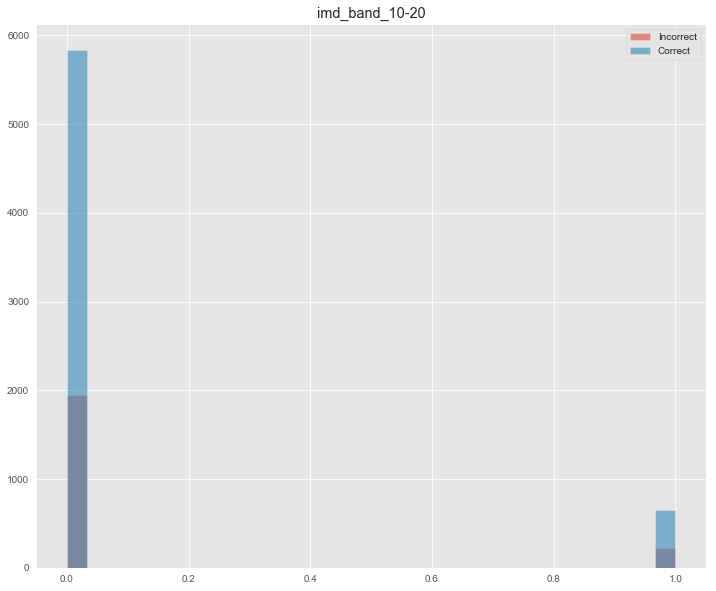

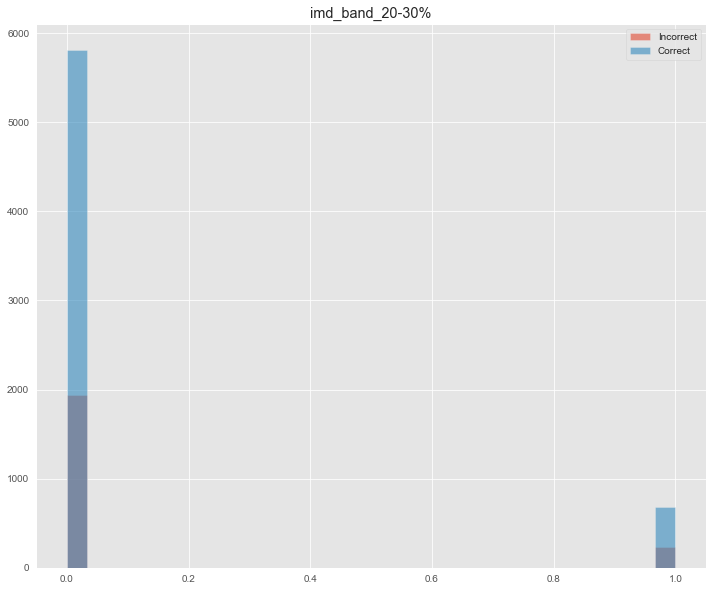

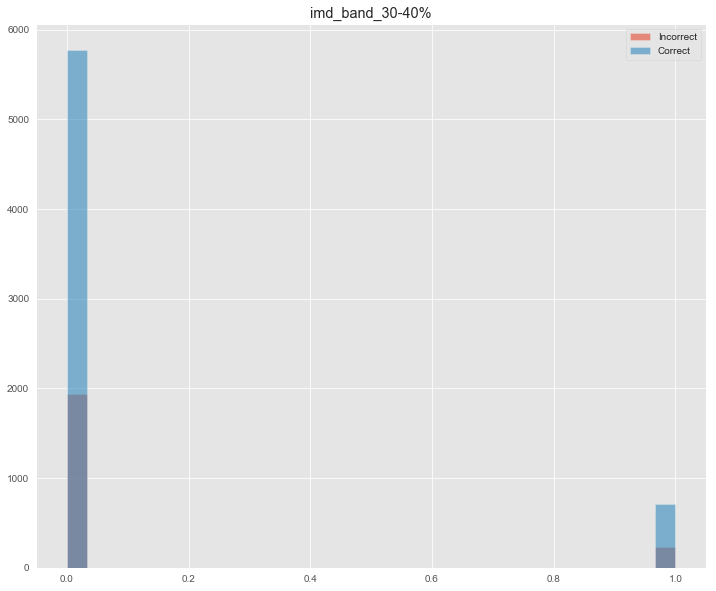

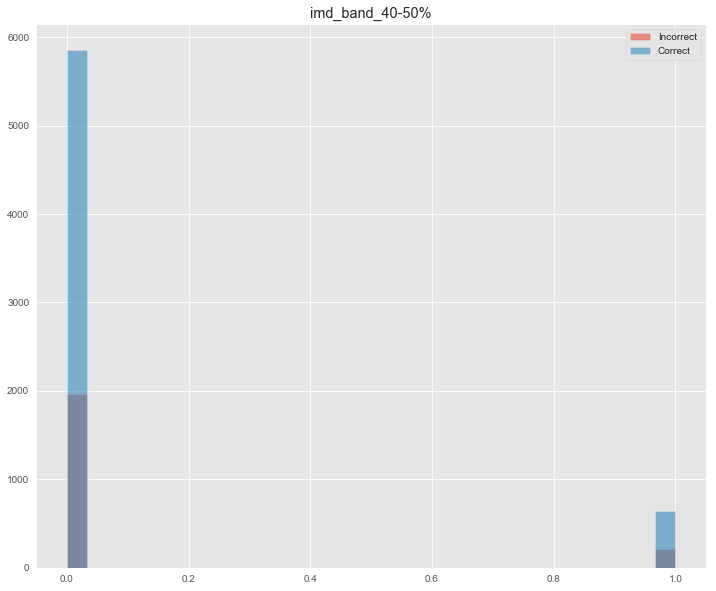

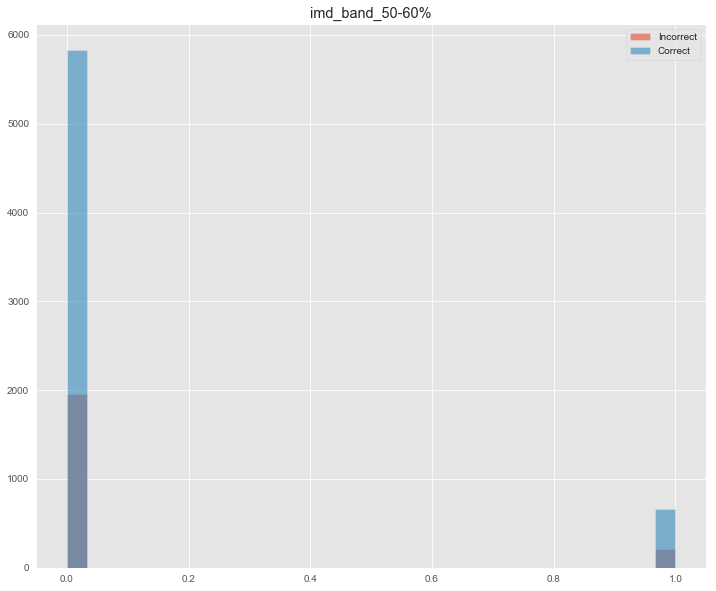

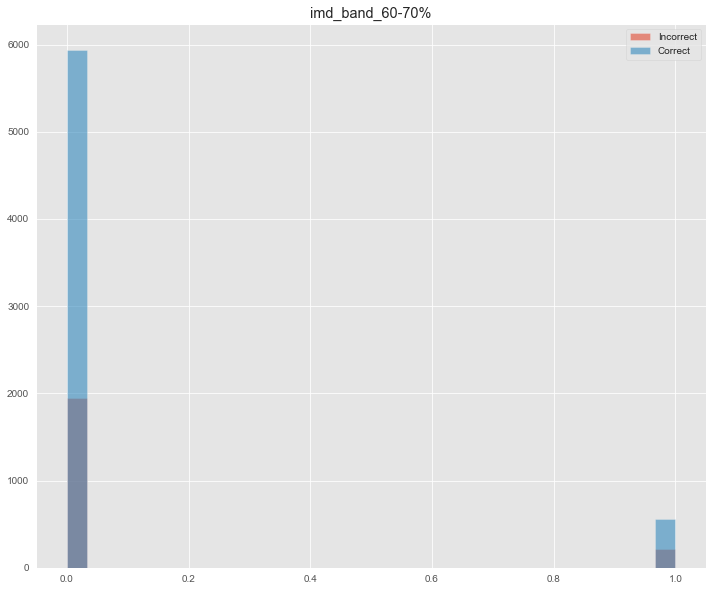

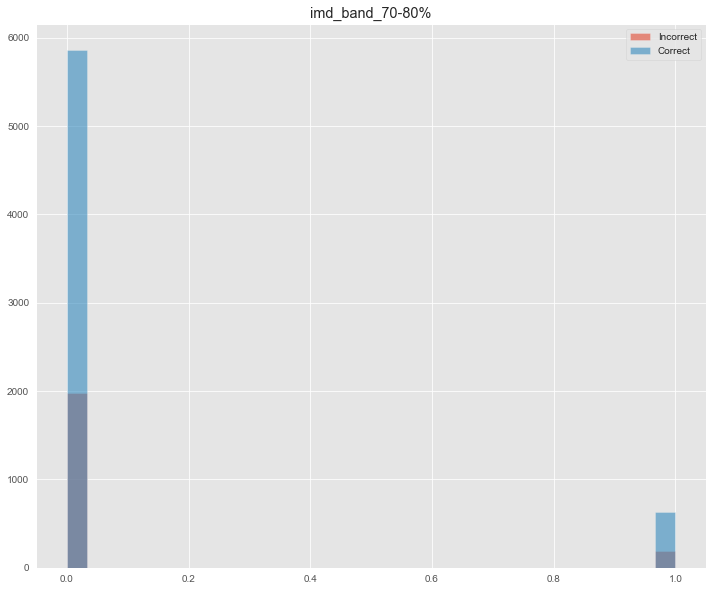

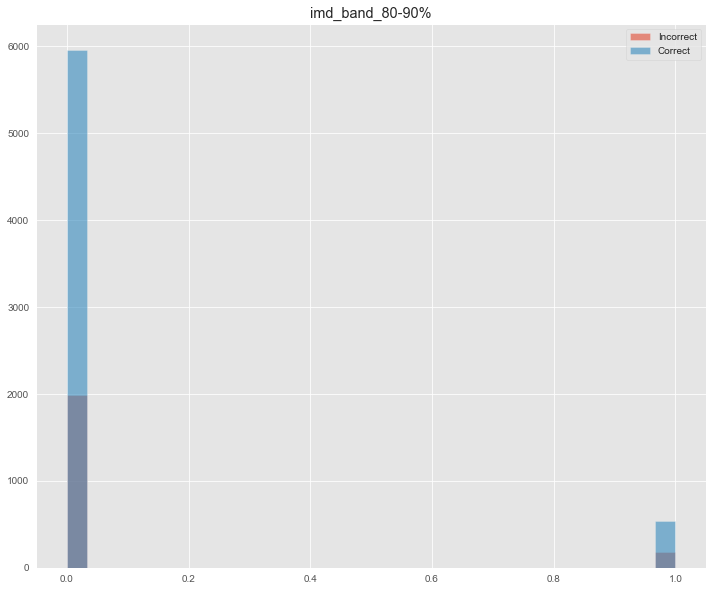

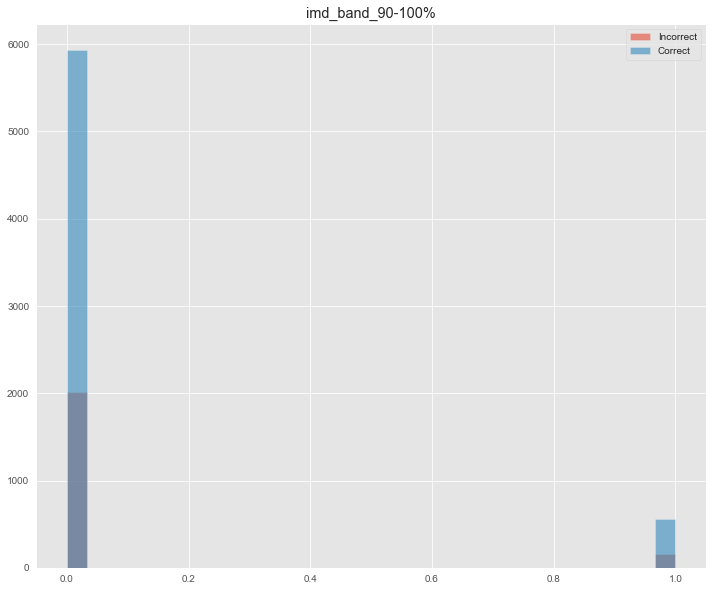

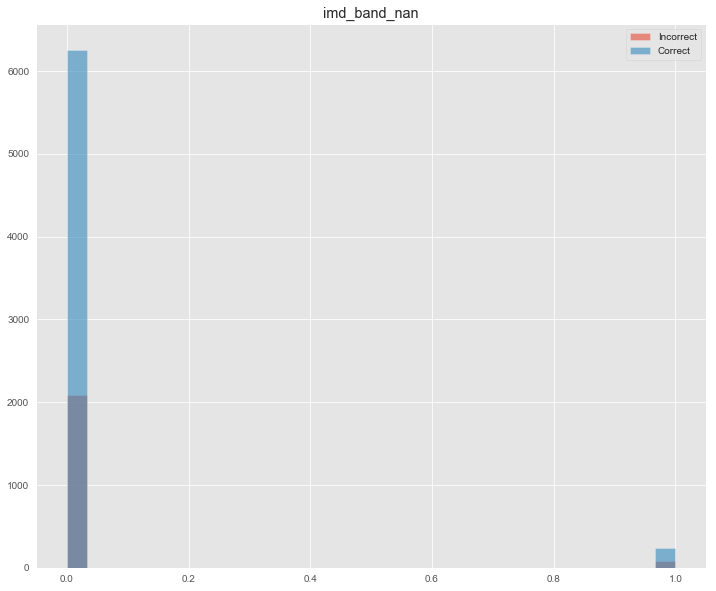

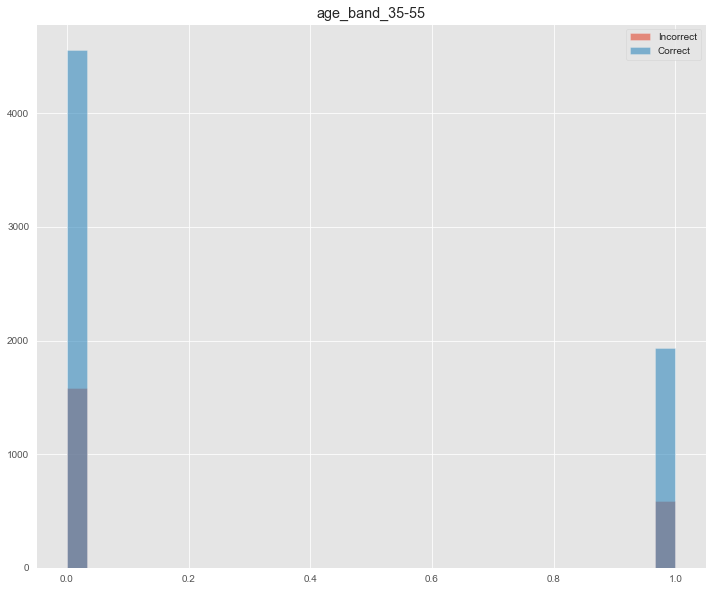

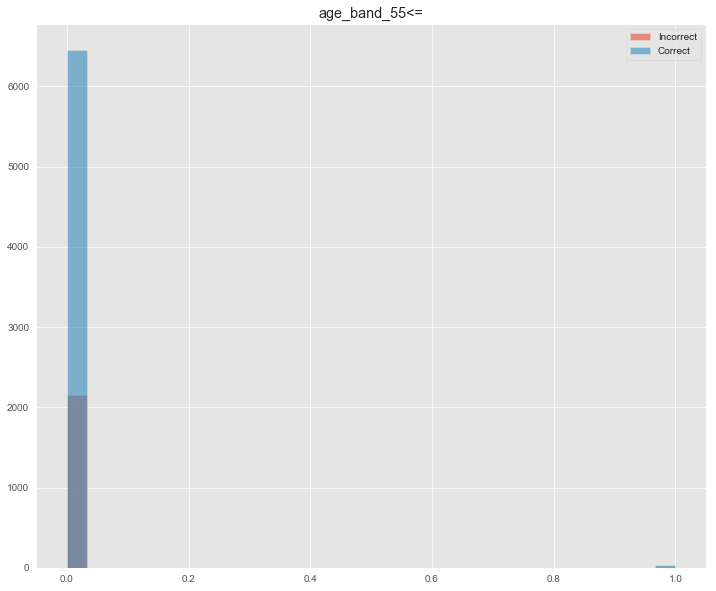

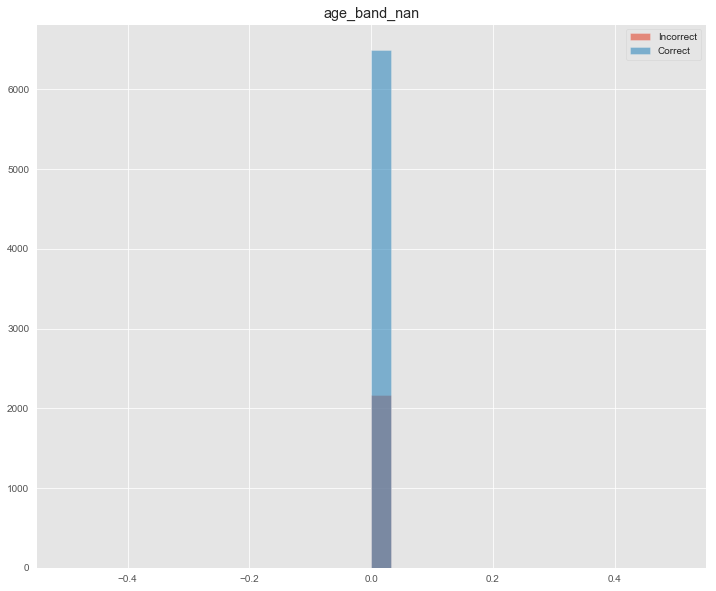

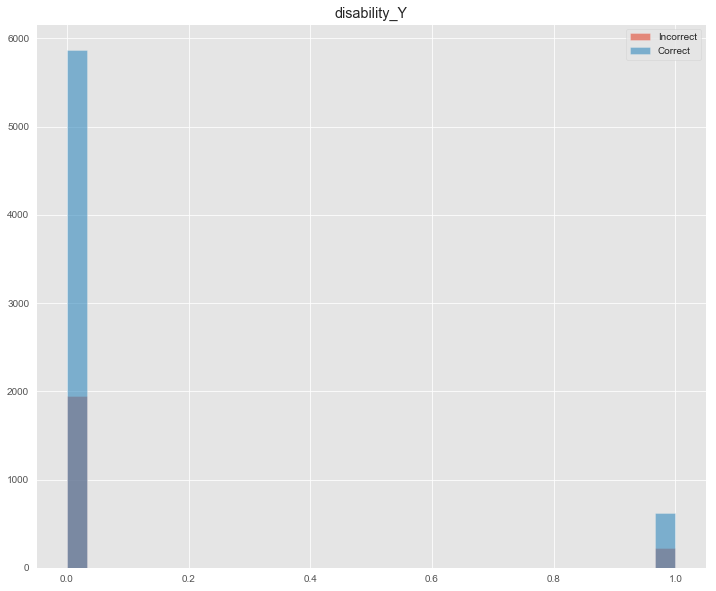

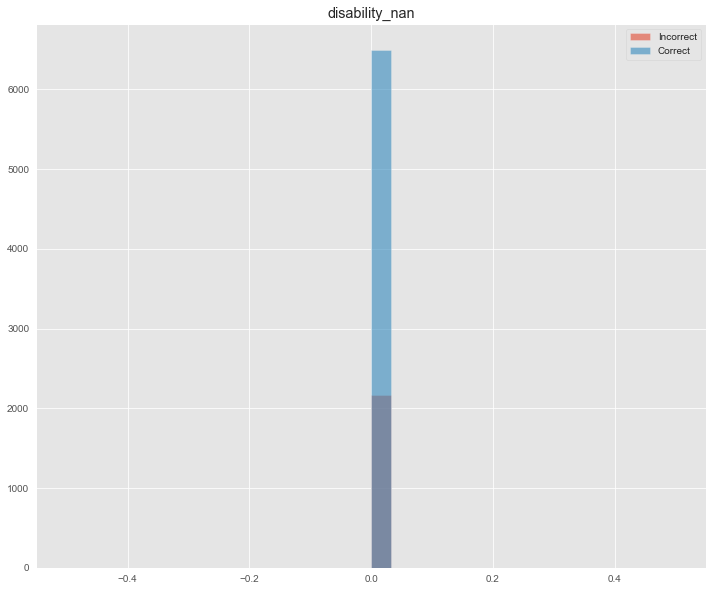

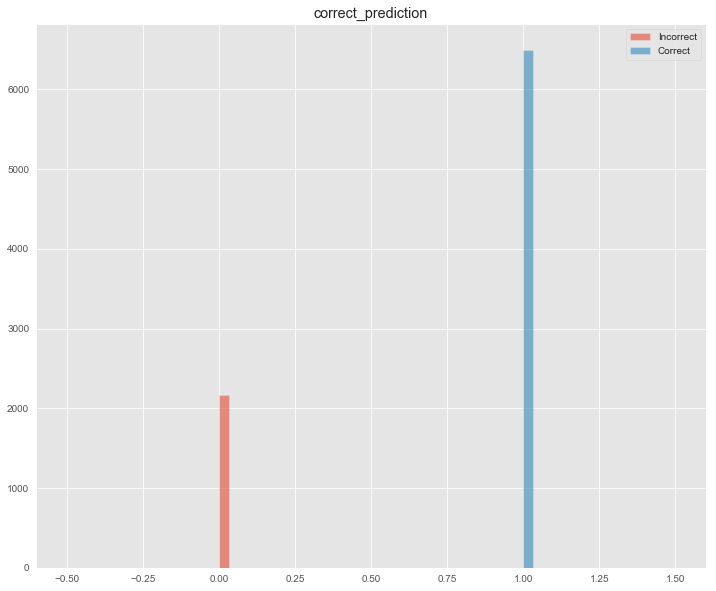

In [34]:
compare_hist(X_test_wrong_pred, X_test_corr_pred, l1='Incorrect', l2='Correct')